# Agent survey simulation

In [1]:
import chart_studio.plotly as py
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
init_notebook_mode(connected = True) #this connect the javascript to the notebook
cf.go_offline() #this allows us to use cufflinks offline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import plotly.express as px

In [3]:
class Agent():
    def __init__(self):
        self.attr = np.random.randn()*16+50
        self.like = []
        self.dislike = []
        self.name = 'optional'
    def choose(self,item):
        self.like.append(item)
    def not_choose(self,item):
        self.dislike.append(item)

In [4]:
class Item():
    def __init__(self):
        self.attr = np.random.rand()*100
        self.a = 0
        self.b = 0
        self.name = 'optional'

### Survey Simulation 

In [5]:
def generate_init_questions(initial_no_of_items,Item):
    #prep the initial questions
    item_list = []
    for i in range(initial_no_of_items):
        init_item = Item()
        init_item.name = 'init item '+str(i)
        item_list.append(init_item)
    return item_list

In [6]:
def do_binary_survey(item_list,agent,tolerance):
    for i in item_list:
        if abs(agent.attr - i.attr) <= tolerance:
            agent.choose(i) # choose method appends this item to its like list for this agent
            i.a += 1
        else:
            agent.not_choose(i) # appends this item to its dislike list for this agent
            i.b += 1

In [7]:
def generate_beta_value_for_items(item_list):
    beta_list = []
    for i in item_list:
        a = i.a + 1  
        b = i.b + 1
        beta_list.append(np.random.beta(a,b))
    return beta_list

In [8]:
def rank_items_based_on_beta(item_list, beta_list):
    max_beta_index = []
    item_list_ranked = []
    for i in range(len(item_list)):
        max_beta_index.append(np.argmax(beta_list)) # max_beta_index contains the index of all items ranked by beta
        beta_list[max_beta_index[-1]] -= 1 # expose the next largest number
    for i in max_beta_index:
        item_list_ranked.append(item_list[i])
    return item_list_ranked

In [9]:
# similar_agent_list = [agent]
# for i in similar_agent_list: # the similar_agent_list and ban_list are updated.
#     find_similar_agents(i)

#similar_agent_list[agent,agent_s1,agent_s2,agent_s1_s1, agent_s2_s1]

def make_ban_list(agent,agent_list,similar_agent_list,ban_list):
    if agent not in similar_agent_list: 
        similar_agent_list.append(agent) #agent is similar to itself
        
    ban_list.extend(agent.like+agent.dislike)
    
    for a in similar_agent_list:
        for other_agent in agent_list:
            for i in a.like: # a.like looks like [item2,item9]
                if i in other_agent.like: # found similar agent # other_agent.like looks like [item9,item20,item30]
                    if other_agent not in similar_agent_list: #if you don't have this statement you will have infinite recurrsion
                        similar_agent_list.append(other_agent)
                        ban_list.extend(other_agent.like+other_agent.dislike) # won't ask agent items in the ban_list
                    break # if agent likes 2 items, and they are both in other_agent like list, then you will extend twice
                          # but you don't want to do that, so you break
    return ban_list

In [10]:
def make_ban_list_for5to20percent(agent,ban_list):
    ban_list.extend(agent.like+agent.dislike)
    return ban_list

In [11]:
def make_asked_list_for5to20percent(agent,agent_list,asked_list):
    for i in agent.like:
        for other_agent in agent_list: # a.like looks like [item2,item9]
            if i in other_agent.like: # found similar agent # other_agent.like looks like [item9,item20,item30]
                for j in (other_agent.like + other_agent.dislike): #this for loop makes sure there is no repeat in asked_list
                    if j not in asked_list:
                        asked_list.append(j) 
    return asked_list

In [12]:
def generate_trade_off_q(item_list_ranked, q_per_tradeoff, ban_list): #pick trade off question based on ban_list and TS
    current_tradeoff_q = []           
    for i in item_list_ranked:
        if i not in (ban_list):
            current_tradeoff_q.append(i)
            if len(current_tradeoff_q) == q_per_tradeoff:
                break 
    return current_tradeoff_q

In [13]:
#pick trade off question based on ban_list, asked_list and TS
def generate_trade_off_q_for5to20percent(item_list_ranked, q_per_tradeoff, ban_list,asked_list): 
    current_tradeoff_q = []
    random.shuffle(asked_list)            
    for i in asked_list: #items in asked_list are items with top beta values. so it's still kind of TS although i'm shuffling
        if i not in ban_list:
            current_tradeoff_q.append(i)
            if len(current_tradeoff_q) + 1 > q_per_tradeoff/2: #choose (less than) half of questions from asked_list
                break
    
    for i in item_list_ranked:
        if i not in (ban_list + asked_list):
            current_tradeoff_q.append(i)
            if len(current_tradeoff_q) == q_per_tradeoff:
                break                 
    # if there is not enough questions in the trade-off question            
    if len(current_tradeoff_q) < q_per_tradeoff: # this may happen if asked_list almost filled the item_list
        print('agent',each_agent, 'ban+asked items almost filled itemlist database.Come back and get some q from asked list again')
        for i in asked_list:
            if i not in (ban_list + current_tradeoff_q):
                current_tradeoff_q.append(i)
                print('revisit asked_list')
                if len(current_tradeoff_q) == q_per_tradeoff:
                    break           
    return current_tradeoff_q

In [14]:
def add_new_item_and_exit(agent,Item,item_list,agent_list):
    # add an item to item_list based on agent attr.
    new_item = Item()
    new_item.attr = agent.attr
    new_item.name = 'from ' + agent.name
    item_list.append(new_item)
    agent.choose(new_item)
    agent_list.append(agent)
    return (item_list,agent_list)

In [46]:
tolerance = 20 
max_turn = 15 # ask 5 round of questions, of each round being one trade-off + binary
q_per_tradeoff = 15 # quetions per trade off question.
number_of_agents = 2000
initial_no_of_items = 5
binary_all_the_way = True

In [47]:
# item_list = [] #found13
# item_list_ranked = [] #found32
diff_list = []
agent_list = []
# beta_list = [] #found30
# max_beta_index = [] #found in function rank_items_based_on_beta 
# current_tradeoff_q = [] #found36
ban_list = [] 
asked_list = []
similar_agent_list = []
liked_idx = [] #contains the index of liked item

#prep the initial questions
item_list = generate_init_questions(initial_no_of_items,Item)



for each_agent in range(number_of_agents):
    if binary_all_the_way == True:
        if max_turn != q_per_tradeoff:
            input('warning: you set binary_all_the_way = True but the value of max_turn and q_per_tradeoff are not equal. You need to set the same value to max_turn and q_per_tradeoff if you are using binary_all_the_way to True. Otherwise the result is not correct. Press any key to quit: ')
            break
    
    agent = Agent()
    agent.name = 'agent ' + str(each_agent)
    turn = 1 #each turn is a combo of trade-off and binary
    
    # Because we only ask 5 turns, and 2 questions per turns, and we have 5 initial questions, 
    # and each agent add one item to the list, by the time the sixth agent enter the survey, 
    # there are 10 questions in the item_list. That's how the "<=max_turn*2-initial_no_of_items" is chosen.
   
    if binary_all_the_way == True:
        threshold = max_turn
    else:
        threshold = max_turn*2
    
    if len(item_list) <= threshold:
        do_binary_survey(item_list,agent,tolerance) #ask all questions in the question database
    # from the seventh agent up, we start to ask trade-off and binary alternatively because 
    # the number of questions is greater than the number of questions we are allowed to ask each agent
    else:
        # get all beta value for each item and get a beta_list
        beta_list = generate_beta_value_for_items(item_list)
        # get a ranked item list based on their beta. First item has the largest beta.
        item_list_ranked = rank_items_based_on_beta(item_list, beta_list)

        while turn <= max_turn:
            if tolerance <=5:
                ban_list = make_ban_list(agent,agent_list,similar_agent_list,ban_list)
                current_tradeoff_q = generate_trade_off_q(item_list_ranked, q_per_tradeoff, ban_list) # get the current trade off questions
            else:
                ban_list = make_ban_list_for5to20percent(agent,ban_list)
                asked_list = make_asked_list_for5to20percent(agent,agent_list,asked_list)
                current_tradeoff_q = generate_trade_off_q_for5to20percent(item_list_ranked, q_per_tradeoff, ban_list,asked_list)
                print('agent',each_agent,'Turn',turn,' tradeoff question')
                for i in current_tradeoff_q:
                    print(i.name.rjust(50,' '))
                
            if len(current_tradeoff_q) == 0: #can't find any unrepeated questions.
                print('agent ',each_agent,'No more unrepeated questions. Exit now')
                break
            #==========================
            #generate diff list
            for i in current_tradeoff_q: 
                diff_list.append(abs(agent.attr - i.attr)) 
                
            # find how many items this agent likes (none or any)
            for i in range(len(diff_list)):
                if min(diff_list) <= tolerance: #like the selected item
                    idx_min = np.argmin(diff_list)
                    liked_idx.append(idx_min) #one agent may like multiple items. So create a list to store the index
                    item_liked = current_tradeoff_q[idx_min]
                    item_liked.a += 1
                    agent.choose(item_liked)
                    diff_list[idx_min] += tolerance # expose the next smallest diff
                    turn += 1
                    
                    if turn > max_turn:
                        break
                else:
                    for count,i in enumerate(current_tradeoff_q):
                        if count not in liked_idx:
                            i.b += 1
                            agent.not_choose(i) 
                    break

                
            turn += 1 # select no on binary, it's one turn
            diff_list = [] # new set of questions, diff_list is reset
            liked_idx = [] # new set of questions, liked_idx is reset 
            
            if binary_all_the_way == True:
                break
            
            if len(current_tradeoff_q) < q_per_tradeoff:
                print('agent ',each_agent,'Not enough questions for this turn. No next turn.')
                break

            if turn > max_turn:
                break  
            
    item_list, agent_list = add_new_item_and_exit(agent,Item,item_list,agent_list)
    
    # New agent coming. Reset following lists
    similar_agent_list = [] # ok
    ban_list = [] # ok
    asked_list = [] # ok
    # beta_list = []
    # max_beta_index = []
    # item_list_ranked = [] 
    

agent 11 Turn 1  tradeoff question
                                     from agent 10
                                       init item 2
                                      from agent 2
                                      from agent 6
                                      from agent 5
                                       init item 0
                                       init item 3
                                      from agent 4
                                      from agent 3
                                      from agent 9
                                      from agent 8
                                      from agent 0
                                       init item 1
                                      from agent 7
                                      from agent 1
agent 12 Turn 1  tradeoff question
                                      from agent 2
                                     from agent 11
                                      from agent 6
            

agent 110 Turn 1  tradeoff question
                                     from agent 95
                                    from agent 103
                                     from agent 66
                                     from agent 23
                                     from agent 65
                                     from agent 31
                                     from agent 72
                                     from agent 87
                                     from agent 15
                                     from agent 32
                                     from agent 75
                                     from agent 62
                                     from agent 88
                                     from agent 73
                                     from agent 26
agent 111 Turn 1  tradeoff question
                                     from agent 97
                                     from agent 88
                                     from agent 85
          

agent 170 Turn 1  tradeoff question
                                    from agent 164
                                    from agent 145
                                    from agent 169
                                    from agent 135
                                    from agent 142
                                    from agent 132
                                    from agent 153
                                     from agent 23
                                    from agent 129
                                    from agent 161
                                    from agent 137
                                     from agent 93
                                     from agent 92
                                     from agent 83
                                    from agent 109
agent 171 Turn 1  tradeoff question
                                     from agent 82
                                     from agent 92
                                     from agent 85
          

agent 220 Turn 1  tradeoff question
                                    from agent 219
                                    from agent 152
                                    from agent 142
                                    from agent 200
                                    from agent 102
                                    from agent 167
                                    from agent 217
                                    from agent 190
                                    from agent 201
                                    from agent 178
                                    from agent 197
                                    from agent 194
                                    from agent 130
                                     from agent 92
                                     from agent 93
agent 221 Turn 1  tradeoff question
                                    from agent 190
                                    from agent 170
                                    from agent 176
          

agent 264 Turn 1  tradeoff question
                                    from agent 210
                                    from agent 246
                                    from agent 145
                                    from agent 241
                                    from agent 147
                                    from agent 163
                                     from agent 93
                                     from agent 98
                                    from agent 142
                                    from agent 153
                                    from agent 238
                                    from agent 137
                                    from agent 239
                                     from agent 59
                                    from agent 113
agent 265 Turn 1  tradeoff question
                                    from agent 219
                                    from agent 173
                                    from agent 203
          

agent 295 Turn 1  tradeoff question
                                    from agent 289
                                    from agent 247
                                    from agent 209
                                    from agent 282
                                    from agent 237
                                     from agent 51
                                    from agent 293
                                    from agent 172
                                    from agent 111
                                    from agent 238
                                    from agent 265
                                    from agent 176
                                     from agent 69
                                     from agent 23
                                    from agent 232
agent 296 Turn 1  tradeoff question
                                    from agent 289
                                    from agent 237
                                    from agent 213
          

agent 328 Turn 1  tradeoff question
                                    from agent 324
                                    from agent 134
                                    from agent 167
                                    from agent 325
                                    from agent 318
                                    from agent 153
                                    from agent 139
                                    from agent 215
                                    from agent 232
                                    from agent 272
                                    from agent 245
                                    from agent 224
                                    from agent 295
                                    from agent 238
                                    from agent 137
agent 329 Turn 1  tradeoff question
                                    from agent 315
                                    from agent 213
                                    from agent 293
          

agent 358 Turn 1  tradeoff question
                                    from agent 344
                                    from agent 356
                                    from agent 349
                                    from agent 235
                                    from agent 354
                                    from agent 249
                                    from agent 351
                                    from agent 320
                                    from agent 190
                                    from agent 186
                                    from agent 114
                                    from agent 137
                                    from agent 142
                                     from agent 74
                                     from agent 92
agent 359 Turn 1  tradeoff question
                                    from agent 253
                                    from agent 356
                                     from agent 73
          

agent 383 Turn 1  tradeoff question
                                    from agent 359
                                    from agent 304
                                    from agent 240
                                    from agent 193
                                    from agent 356
                                    from agent 289
                                     from agent 69
                                    from agent 294
                                    from agent 361
                                    from agent 176
                                    from agent 311
                                    from agent 259
                                    from agent 320
                                    from agent 229
                                     from agent 41
agent 384 Turn 1  tradeoff question
                                    from agent 361
                                    from agent 330
                                    from agent 372
          

agent 407 Turn 1  tradeoff question
                                    from agent 401
                                    from agent 365
                                    from agent 404
                                    from agent 207
                                    from agent 295
                                    from agent 373
                                    from agent 164
                                    from agent 247
                                    from agent 390
                                    from agent 288
                                    from agent 128
                                    from agent 137
                                    from agent 337
                                     from agent 85
                                    from agent 375
agent 408 Turn 1  tradeoff question
                                    from agent 391
                                    from agent 401
                                    from agent 404
          

agent 428 Turn 1  tradeoff question
                                    from agent 390
                                    from agent 425
                                    from agent 405
                                    from agent 277
                                    from agent 320
                                    from agent 281
                                    from agent 427
                                    from agent 418
                                    from agent 385
                                    from agent 142
                                    from agent 309
                                    from agent 311
                                    from agent 328
                                    from agent 102
                                    from agent 245
agent 429 Turn 1  tradeoff question
                                    from agent 391
                                    from agent 417
                                    from agent 381
          

agent 449 Turn 1  tradeoff question
                                    from agent 421
                                    from agent 340
                                    from agent 445
                                    from agent 311
                                    from agent 288
                                    from agent 309
                                    from agent 328
                                    from agent 395
                                    from agent 388
                                    from agent 401
                                    from agent 440
                                     from agent 51
                                    from agent 271
                                    from agent 390
                                    from agent 418
agent 450 Turn 1  tradeoff question
                                    from agent 421
                                    from agent 391
                                    from agent 444
          

agent 468 Turn 1  tradeoff question
                                    from agent 445
                                    from agent 447
                                    from agent 138
                                    from agent 311
                                    from agent 405
                                    from agent 430
                                    from agent 356
                                    from agent 242
                                    from agent 418
                                    from agent 425
                                    from agent 390
                                    from agent 328
                                    from agent 391
                                    from agent 417
                                    from agent 167
agent 469 Turn 1  tradeoff question
                                    from agent 311
                                    from agent 417
                                    from agent 424
          

agent 486 Turn 1  tradeoff question
                                    from agent 475
                                    from agent 463
                                    from agent 432
                                    from agent 469
                                    from agent 337
                                    from agent 399
                                    from agent 372
                                    from agent 416
                                    from agent 393
                                    from agent 429
                                    from agent 424
                                    from agent 320
                                    from agent 400
                                    from agent 381
                                    from agent 245
agent 487 Turn 1  tradeoff question
                                    from agent 458
                                    from agent 257
                                    from agent 445
          

agent 503 Turn 1  tradeoff question
                                    from agent 469
                                    from agent 483
                                    from agent 430
                                    from agent 464
                                    from agent 444
                                    from agent 390
                                     from agent 51
                                    from agent 432
                                    from agent 230
                                    from agent 380
                                    from agent 476
                                    from agent 281
                                    from agent 309
                                    from agent 418
                                    from agent 406
agent 504 Turn 1  tradeoff question
                                    from agent 444
                                    from agent 340
                                    from agent 424
          

agent 520 Turn 1  tradeoff question
                                    from agent 376
                                    from agent 507
                                    from agent 418
                                    from agent 496
                                    from agent 469
                                    from agent 452
                                    from agent 393
                                    from agent 510
                                    from agent 281
                                    from agent 355
                                    from agent 424
                                    from agent 405
                                    from agent 196
                                    from agent 347
                                    from agent 234
agent 521 Turn 1  tradeoff question
                                    from agent 519
                                    from agent 497
                                    from agent 512
          

agent 537 Turn 1  tradeoff question
                                    from agent 528
                                    from agent 518
                                    from agent 405
                                    from agent 479
                                    from agent 420
                                    from agent 445
                                    from agent 390
                                    from agent 424
                                    from agent 418
                                    from agent 436
                                    from agent 167
                                    from agent 311
                                    from agent 372
                                    from agent 393
                                    from agent 293
agent 538 Turn 1  tradeoff question
                                    from agent 364
                                    from agent 526
                                    from agent 222
          

agent 554 Turn 1  tradeoff question
                                    from agent 537
                                    from agent 227
                                    from agent 536
                                    from agent 385
                                    from agent 336
                                    from agent 543
                                    from agent 518
                                    from agent 346
                                    from agent 337
                                    from agent 424
                                    from agent 499
                                    from agent 418
                                    from agent 347
                                    from agent 359
                                    from agent 540
agent 555 Turn 1  tradeoff question
                                    from agent 551
                                    from agent 483
                                    from agent 390
          

agent 570 Turn 1  tradeoff question
                                    from agent 565
                                    from agent 550
                                    from agent 474
                                    from agent 530
                                    from agent 552
                                    from agent 548
                                    from agent 309
                                    from agent 538
                                    from agent 418
                                    from agent 499
                                    from agent 464
                                    from agent 196
                                    from agent 251
                                    from agent 483
                                    from agent 479
agent 571 Turn 1  tradeoff question
                                    from agent 550
                                    from agent 559
                                    from agent 530
          

agent 586 Turn 1  tradeoff question
                                    from agent 552
                                    from agent 548
                                    from agent 534
                                    from agent 532
                                    from agent 242
                                    from agent 567
                                    from agent 540
                                    from agent 542
                                    from agent 523
                                    from agent 580
                                    from agent 405
                                    from agent 527
                                    from agent 111
                                    from agent 169
                                    from agent 356
agent 587 Turn 1  tradeoff question
                                    from agent 577
                                    from agent 584
                                    from agent 512
          

agent 599 Turn 1  tradeoff question
                                    from agent 589
                                    from agent 577
                                    from agent 199
                                    from agent 553
                                    from agent 487
                                    from agent 132
                                    from agent 418
                                    from agent 531
                                    from agent 270
                                    from agent 152
                                    from agent 406
                                    from agent 272
                                    from agent 474
                                    from agent 206
                                    from agent 532
agent 600 Turn 1  tradeoff question
                                    from agent 595
                                    from agent 580
                                    from agent 573
          

agent 614 Turn 1  tradeoff question
                                    from agent 583
                                    from agent 534
                                    from agent 536
                                    from agent 607
                                    from agent 445
                                    from agent 281
                                    from agent 434
                                    from agent 407
                                    from agent 599
                                    from agent 418
                                    from agent 395
                                    from agent 372
                                    from agent 381
                                    from agent 526
                                    from agent 273
agent 615 Turn 1  tradeoff question
                                    from agent 589
                                    from agent 301
                                    from agent 483
          

agent 627 Turn 1  tradeoff question
                                    from agent 313
                                    from agent 534
                                    from agent 563
                                    from agent 602
                                    from agent 610
                                    from agent 593
                                    from agent 471
                                    from agent 281
                                    from agent 583
                                    from agent 614
                                    from agent 536
                                    from agent 619
                                    from agent 560
                                    from agent 605
                                    from agent 272
agent 628 Turn 1  tradeoff question
                                    from agent 618
                                    from agent 445
                                    from agent 616
          

agent 641 Turn 1  tradeoff question
                                    from agent 431
                                    from agent 509
                                    from agent 395
                                    from agent 560
                                    from agent 608
                                    from agent 591
                                    from agent 418
                                    from agent 167
                                    from agent 385
                                    from agent 320
                                    from agent 464
                                    from agent 583
                                    from agent 270
                                    from agent 552
                                    from agent 536
agent 642 Turn 1  tradeoff question
                                    from agent 638
                                    from agent 587
                                    from agent 463
          

agent 652 Turn 1  tradeoff question
                                    from agent 645
                                    from agent 592
                                    from agent 610
                                    from agent 379
                                    from agent 618
                                    from agent 497
                                    from agent 550
                                    from agent 601
                                    from agent 178
                                    from agent 453
                                    from agent 602
                                    from agent 381
                                    from agent 542
                                    from agent 599
                                    from agent 625
agent 653 Turn 1  tradeoff question
                                    from agent 611
                                    from agent 644
                                    from agent 565
          

agent 663 Turn 1  tradeoff question
                                    from agent 566
                                    from agent 580
                                    from agent 550
                                    from agent 474
                                    from agent 515
                                    from agent 340
                                    from agent 219
                                    from agent 599
                                    from agent 367
                                    from agent 381
                                    from agent 395
                                    from agent 394
                                     from agent 23
                                    from agent 645
                                    from agent 137
agent 664 Turn 1  tradeoff question
                                    from agent 636
                                    from agent 212
                                     from agent 56
          

agent 683 Turn 1  tradeoff question
                                    from agent 621
                                    from agent 600
                                    from agent 644
                                    from agent 678
                                    from agent 606
                                    from agent 281
                                    from agent 520
                                     from agent 88
                                    from agent 445
                                    from agent 488
                                    from agent 142
                                    from agent 631
                                    from agent 547
                                    from agent 294
                                    from agent 571
agent 684 Turn 1  tradeoff question
                                    from agent 601
                                    from agent 680
                                    from agent 526
          

agent 703 Turn 1  tradeoff question
                                    from agent 694
                                    from agent 693
                                    from agent 639
                                    from agent 599
                                    from agent 393
                                    from agent 424
                                    from agent 447
                                    from agent 192
                                    from agent 183
                                    from agent 356
                                    from agent 464
                                    from agent 340
                                    from agent 534
                                    from agent 281
                                    from agent 167
agent 704 Turn 1  tradeoff question
                                    from agent 692
                                    from agent 471
                                    from agent 700
          

agent 724 Turn 1  tradeoff question
                                    from agent 715
                                    from agent 651
                                    from agent 706
                                    from agent 688
                                    from agent 569
                                    from agent 707
                                    from agent 544
                                    from agent 563
                                    from agent 361
                                    from agent 552
                                    from agent 640
                                    from agent 698
                                    from agent 535
                                    from agent 497
                                     from agent 71
agent 725 Turn 1  tradeoff question
                                    from agent 672
                                    from agent 707
                                    from agent 497
          

agent 744 Turn 1  tradeoff question
                                    from agent 733
                                    from agent 725
                                    from agent 700
                                    from agent 695
                                    from agent 653
                                    from agent 629
                                    from agent 718
                                    from agent 601
                                    from agent 727
                                    from agent 331
                                    from agent 457
                                    from agent 201
                                    from agent 303
                                    from agent 209
                                    from agent 703
agent 745 Turn 1  tradeoff question
                                    from agent 732
                                    from agent 725
                                    from agent 744
          

agent 762 Turn 1  tradeoff question
                                    from agent 693
                                    from agent 722
                                    from agent 627
                                    from agent 401
                                    from agent 614
                                    from agent 341
                                    from agent 679
                                    from agent 520
                                    from agent 706
                                    from agent 447
                                    from agent 251
                                    from agent 518
                                    from agent 253
                                    from agent 599
                                    from agent 199
agent 763 Turn 1  tradeoff question
                                    from agent 762
                                    from agent 626
                                    from agent 745
          

agent 779 Turn 1  tradeoff question
                                    from agent 569
                                    from agent 192
                                    from agent 772
                                    from agent 718
                                    from agent 758
                                    from agent 765
                                    from agent 699
                                    from agent 709
                                    from agent 455
                                    from agent 738
                                    from agent 193
                                    from agent 703
                                    from agent 183
                                    from agent 501
                                    from agent 753
agent 780 Turn 1  tradeoff question
                                    from agent 764
                                    from agent 108
                                    from agent 729
          

agent 796 Turn 1  tradeoff question
                                    from agent 331
                                    from agent 777
                                    from agent 754
                                    from agent 574
                                    from agent 794
                                    from agent 732
                                    from agent 267
                                    from agent 644
                                    from agent 391
                                    from agent 393
                                    from agent 183
                                    from agent 758
                                    from agent 230
                                    from agent 192
                                    from agent 355
agent 797 Turn 1  tradeoff question
                                    from agent 770
                                    from agent 789
                                    from agent 711
          

agent 814 Turn 1  tradeoff question
                                    from agent 805
                                    from agent 766
                                    from agent 802
                                    from agent 414
                                    from agent 798
                                    from agent 530
                                    from agent 810
                                    from agent 784
                                    from agent 723
                                    from agent 636
                                    from agent 725
                                    from agent 792
                                    from agent 534
                                    from agent 605
                                    from agent 745
agent 815 Turn 1  tradeoff question
                                    from agent 674
                                    from agent 315
                                    from agent 694
          

agent 832 Turn 1  tradeoff question
                                    from agent 650
                                    from agent 788
                                    from agent 801
                                    from agent 611
                                    from agent 795
                                    from agent 692
                                    from agent 395
                                    from agent 222
                                    from agent 569
                                    from agent 280
                                    from agent 272
                                    from agent 684
                                    from agent 196
                                    from agent 776
                                    from agent 737
agent 833 Turn 1  tradeoff question
                                    from agent 830
                                    from agent 716
                                    from agent 686
          

agent 848 Turn 1  tradeoff question
                                    from agent 830
                                    from agent 756
                                    from agent 786
                                    from agent 834
                                    from agent 787
                                    from agent 732
                                    from agent 692
                                    from agent 612
                                    from agent 679
                                    from agent 809
                                    from agent 563
                                    from agent 346
                                    from agent 480
                                    from agent 561
                                    from agent 356
agent 849 Turn 1  tradeoff question
                                    from agent 835
                                    from agent 821
                                    from agent 830
          

agent 869 Turn 1  tradeoff question
                                    from agent 819
                                    from agent 816
                                    from agent 745
                                    from agent 725
                                    from agent 849
                                    from agent 766
                                    from agent 821
                                    from agent 249
                                    from agent 807
                                    from agent 461
                                    from agent 756
                                    from agent 222
                                    from agent 424
                                    from agent 280
                                    from agent 801
agent 870 Turn 1  tradeoff question
                                    from agent 867
                                    from agent 835
                                    from agent 783
          

agent 885 Turn 1  tradeoff question
                                    from agent 876
                                    from agent 881
                                    from agent 816
                                    from agent 827
                                    from agent 868
                                    from agent 611
                                    from agent 591
                                    from agent 539
                                    from agent 723
                                    from agent 803
                                    from agent 802
                                    from agent 113
                                    from agent 586
                                    from agent 639
                                    from agent 871
agent 886 Turn 1  tradeoff question
                                    from agent 849
                                    from agent 885
                                    from agent 847
          

agent 909 Turn 1  tradeoff question
                                    from agent 874
                                    from agent 881
                                    from agent 889
                                    from agent 682
                                    from agent 901
                                    from agent 654
                                    from agent 903
                                    from agent 869
                                    from agent 588
                                    from agent 673
                                    from agent 873
                                    from agent 651
                                    from agent 417
                                    from agent 877
                                    from agent 606
agent 910 Turn 1  tradeoff question
                                    from agent 873
                                    from agent 881
                                    from agent 837
          

agent 924 Turn 1  tradeoff question
                                    from agent 923
                                    from agent 904
                                    from agent 612
                                    from agent 873
                                    from agent 678
                                    from agent 845
                                    from agent 642
                                    from agent 249
                                    from agent 714
                                    from agent 669
                                    from agent 132
                                    from agent 860
                                    from agent 335
                                    from agent 771
                                    from agent 616
agent 925 Turn 1  tradeoff question
                                    from agent 918
                                    from agent 827
                                    from agent 902
          

agent 936 Turn 1  tradeoff question
                                    from agent 887
                                    from agent 908
                                    from agent 928
                                    from agent 788
                                    from agent 888
                                    from agent 802
                                    from agent 612
                                    from agent 673
                                    from agent 186
                                    from agent 865
                                    from agent 745
                                    from agent 878
                                    from agent 480
                                    from agent 816
                                    from agent 425
agent 937 Turn 1  tradeoff question
                                    from agent 934
                                    from agent 887
                                    from agent 888
          

agent 949 Turn 1  tradeoff question
                                    from agent 944
                                    from agent 940
                                    from agent 830
                                    from agent 618
                                    from agent 591
                                    from agent 817
                                    from agent 249
                                    from agent 939
                                    from agent 893
                                    from agent 379
                                    from agent 818
                                    from agent 785
                                    from agent 402
                                    from agent 853
                                    from agent 879
agent 950 Turn 1  tradeoff question
                                    from agent 910
                                    from agent 936
                                    from agent 920
          

agent 962 Turn 1  tradeoff question
                                    from agent 910
                                    from agent 948
                                    from agent 936
                                    from agent 909
                                    from agent 941
                                    from agent 788
                                    from agent 939
                                    from agent 905
                                    from agent 835
                                    from agent 602
                                    from agent 831
                                    from agent 185
                                    from agent 837
                                    from agent 904
                                    from agent 903
agent 963 Turn 1  tradeoff question
                                    from agent 957
                                    from agent 914
                                    from agent 884
          

agent 974 Turn 1  tradeoff question
                                    from agent 943
                                    from agent 953
                                    from agent 944
                                    from agent 938
                                    from agent 854
                                    from agent 788
                                    from agent 808
                                    from agent 905
                                    from agent 960
                                    from agent 766
                                    from agent 909
                                    from agent 164
                                    from agent 356
                                    from agent 584
                                    from agent 314
agent 975 Turn 1  tradeoff question
                                    from agent 967
                                    from agent 944
                                    from agent 969
          

agent 986 Turn 1  tradeoff question
                                    from agent 950
                                    from agent 982
                                    from agent 973
                                    from agent 629
                                    from agent 960
                                    from agent 831
                                    from agent 914
                                     from agent 26
                                    from agent 668
                                    from agent 432
                                    from agent 865
                                    from agent 148
                                    from agent 569
                                    from agent 445
                                    from agent 140
agent 987 Turn 1  tradeoff question
                                    from agent 982
                                    from agent 947
                                    from agent 979
          

agent 998 Turn 1  tradeoff question
                                    from agent 944
                                    from agent 989
                                    from agent 984
                                    from agent 871
                                    from agent 606
                                    from agent 844
                                    from agent 734
                                    from agent 654
                                    from agent 823
                                    from agent 644
                                    from agent 947
                                    from agent 213
                                    from agent 362
                                    from agent 196
                                    from agent 160
agent 999 Turn 1  tradeoff question
                                    from agent 978
                                    from agent 862
                                    from agent 887
          

agent 1010 Turn 1  tradeoff question
                                   from agent 1003
                                    from agent 970
                                    from agent 948
                                    from agent 828
                                    from agent 944
                                    from agent 960
                                    from agent 519
                                    from agent 668
                                    from agent 950
                                    from agent 954
                                    from agent 956
                                   from agent 1002
                                    from agent 931
                                    from agent 729
                                    from agent 868
agent 1011 Turn 1  tradeoff question
                                    from agent 980
                                    from agent 707
                                   from agent 1000
        

agent 1022 Turn 1  tradeoff question
                                    from agent 944
                                    from agent 746
                                    from agent 978
                                    from agent 979
                                   from agent 1015
                                    from agent 865
                                    from agent 854
                                    from agent 683
                                    from agent 914
                                   from agent 1014
                                   from agent 1013
                                    from agent 389
                                    from agent 654
                                    from agent 970
                                    from agent 732
agent 1023 Turn 1  tradeoff question
                                    from agent 992
                                    from agent 979
                                   from agent 1019
        

agent 1034 Turn 1  tradeoff question
                                    from agent 979
                                    from agent 944
                                    from agent 865
                                    from agent 677
                                    from agent 756
                                    from agent 987
                                    from agent 914
                                    from agent 819
                                    from agent 523
                                    from agent 601
                                    from agent 219
                                    from agent 537
                                   from agent 1018
                                    from agent 757
                                    from agent 356
agent 1035 Turn 1  tradeoff question
                                   from agent 1009
                                    from agent 980
                                    from agent 952
        

agent 1045 Turn 1  tradeoff question
                                   from agent 1037
                                   from agent 1011
                                   from agent 1035
                                    from agent 973
                                    from agent 922
                                   from agent 1031
                                    from agent 980
                                   from agent 1009
                                    from agent 466
                                   from agent 1030
                                    from agent 579
                                    from agent 957
                                    from agent 654
                                    from agent 818
                                   from agent 1044
agent 1046 Turn 1  tradeoff question
                                   from agent 1019
                                    from agent 770
                                    from agent 654
        

agent 1057 Turn 1  tradeoff question
                                   from agent 1052
                                   from agent 1011
                                    from agent 980
                                    from agent 922
                                   from agent 1012
                                    from agent 956
                                    from agent 813
                                    from agent 636
                                    from agent 978
                                    from agent 660
                                   from agent 1019
                                    from agent 425
                                    from agent 787
                                   from agent 1036
                                    from agent 871
agent 1058 Turn 1  tradeoff question
                                   from agent 1011
                                   from agent 1031
                                    from agent 980
        

agent 1072 Turn 1  tradeoff question
                                   from agent 1051
                                    from agent 952
                                    from agent 910
                                   from agent 1044
                                    from agent 595
                                    from agent 950
                                    from agent 336
                                    from agent 549
                                    from agent 788
                                    from agent 346
                                   from agent 1047
                                    from agent 914
                                    from agent 692
                                    from agent 356
                                    from agent 816
agent 1073 Turn 1  tradeoff question
                                   from agent 1066
                                   from agent 1047
                                    from agent 957
        

agent 1087 Turn 1  tradeoff question
                                    from agent 762
                                   from agent 1084
                                   from agent 1071
                                    from agent 981
                                   from agent 1051
                                    from agent 968
                                   from agent 1078
                                    from agent 613
                                    from agent 819
                                    from agent 591
                                   from agent 1026
                                   from agent 1031
                                    from agent 893
                                    from agent 917
                                   from agent 1044
agent 1088 Turn 1  tradeoff question
                                   from agent 1047
                                    from agent 981
                                   from agent 1058
        

agent 1102 Turn 1  tradeoff question
                                    from agent 896
                                   from agent 1062
                                   from agent 1051
                                    from agent 729
                                   from agent 1036
                                    from agent 321
                                    from agent 654
                                   from agent 1097
                                   from agent 1019
                                   from agent 1096
                                    from agent 777
                                    from agent 956
                                    from agent 950
                                    from agent 114
                                    from agent 952
agent 1103 Turn 1  tradeoff question
                                   from agent 1024
                                   from agent 1066
                                   from agent 1092
        

agent 1117 Turn 1  tradeoff question
                                   from agent 1059
                                   from agent 1082
                                    from agent 213
                                   from agent 1056
                                   from agent 1069
                                    from agent 879
                                    from agent 959
                                   from agent 1107
                                    from agent 664
                                    from agent 336
                                    from agent 896
                                    from agent 561
                                    from agent 584
                                    from agent 989
                                     from agent 62
agent 1118 Turn 1  tradeoff question
                                   from agent 1069
                                   from agent 1086
                                   from agent 1051
        

agent 1132 Turn 1  tradeoff question
                                    from agent 952
                                   from agent 1015
                                   from agent 1058
                                    from agent 984
                                    from agent 499
                                    from agent 888
                                    from agent 788
                                    from agent 706
                                    from agent 348
                                   from agent 1127
                                   from agent 1031
                                   from agent 1065
                                    from agent 257
                                    from agent 335
                                   from agent 1066
agent 1133 Turn 1  tradeoff question
                                   from agent 1118
                                   from agent 1030
                                   from agent 1119
        

agent 1147 Turn 1  tradeoff question
                                   from agent 1139
                                   from agent 1000
                                   from agent 1031
                                    from agent 999
                                    from agent 669
                                   from agent 1059
                                   from agent 1112
                                   from agent 1086
                                    from agent 802
                                   from agent 1024
                                    from agent 395
                                    from agent 210
                                    from agent 920
                                    from agent 786
                                    from agent 604
agent 1148 Turn 1  tradeoff question
                                   from agent 1137
                                   from agent 1105
                                   from agent 1089
        

agent 1162 Turn 1  tradeoff question
                                   from agent 1077
                                   from agent 1103
                                   from agent 1010
                                   from agent 1124
                                    from agent 844
                                    from agent 995
                                    from agent 613
                                    from agent 821
                                   from agent 1035
                                    from agent 261
                                    from agent 523
                                    from agent 895
                                    from agent 108
                                    from agent 518
                                    from agent 843
agent 1163 Turn 1  tradeoff question
                                    from agent 613
                                   from agent 1053
                                   from agent 1052
        

agent 1177 Turn 1  tradeoff question
                                    from agent 905
                                   from agent 1161
                                    from agent 754
                                   from agent 1176
                                    from agent 988
                                   from agent 1154
                                   from agent 1031
                                    from agent 657
                                   from agent 1098
                                    from agent 313
                                    from agent 914
                                   from agent 1013
                                    from agent 649
                                   from agent 1078
                                    from agent 727
agent 1178 Turn 1  tradeoff question
                                   from agent 1144
                                   from agent 1167
                                   from agent 1163
        

agent 1190 Turn 1  tradeoff question
                                   from agent 1024
                                   from agent 1124
                                   from agent 1100
                                    from agent 994
                                   from agent 1177
                                   from agent 1108
                                    from agent 960
                                   from agent 1174
                                    from agent 401
                                    from agent 746
                                    from agent 790
                                    from agent 654
                                    from agent 865
                                    from agent 862
                                   from agent 1037
agent 1191 Turn 1  tradeoff question
                                   from agent 1183
                                   from agent 1181
                                    from agent 878
        

agent 1203 Turn 1  tradeoff question
                                   from agent 1189
                                    from agent 762
                                    from agent 654
                                   from agent 1168
                                    from agent 871
                                    from agent 549
                                   from agent 1176
                                    from agent 613
                                   from agent 1108
                                   from agent 1033
                                   from agent 1065
                                    from agent 214
                                    from agent 257
                                    from agent 865
                                    from agent 992
agent 1204 Turn 1  tradeoff question
                                   from agent 1180
                                   from agent 1083
                                   from agent 1077
        

agent 1216 Turn 1  tradeoff question
                                   from agent 1072
                                   from agent 1187
                                   from agent 1177
                                    from agent 788
                                    from agent 108
                                    from agent 865
                                   from agent 1180
                                    from agent 970
                                    from agent 807
                                    from agent 784
                                    from agent 988
                                   from agent 1027
                                    from agent 771
                                   from agent 1184
                                   from agent 1210
agent 1217 Turn 1  tradeoff question
                                   from agent 1216
                                    from agent 730
                                   from agent 1049
        

                                    from agent 929
                                   from agent 1176
                                   from agent 1195
                                    from agent 971
                                    from agent 889
                                   from agent 1132
                                    from agent 613
                                    from agent 944
                                    from agent 779
                                   from agent 1205
                                   from agent 1150
                                    from agent 591
                                   from agent 1155
                                   from agent 1004
                                    from agent 988
agent 1229 Turn 1  tradeoff question
                                   from agent 1205
                                   from agent 1173
                                   from agent 1184
                                   from agent

agent 1244 Turn 1  tradeoff question
                                   from agent 1207
                                   from agent 1236
                                   from agent 1160
                                   from agent 1223
                                   from agent 1184
                                   from agent 1126
                                    from agent 887
                                   from agent 1220
                                   from agent 1195
                                   from agent 1061
                                    from agent 970
                                    from agent 391
                                    from agent 834
                                   from agent 1235
                                    from agent 629
agent 1245 Turn 1  tradeoff question
                                   from agent 1207
                                   from agent 1242
                                    from agent 939
        

agent 1259 Turn 1  tradeoff question
                                   from agent 1069
                                   from agent 1252
                                   from agent 1174
                                   from agent 1251
                                   from agent 1216
                                    from agent 886
                                    from agent 754
                                   from agent 1223
                                   from agent 1235
                                    from agent 138
                                    from agent 971
                                    from agent 776
                                    from agent 821
                                    from agent 988
                                    from agent 678
agent 1260 Turn 1  tradeoff question
                                   from agent 1255
                                   from agent 1064
                                   from agent 1213
        

agent 1271 Turn 1  tradeoff question
                                   from agent 1203
                                   from agent 1268
                                    from agent 759
                                   from agent 1256
                                    from agent 910
                                   from agent 1127
                                   from agent 1078
                                    from agent 988
                                    from agent 942
                                   from agent 1212
                                    from agent 680
                                    from agent 532
                                   from agent 1176
                                    from agent 505
                                    from agent 420
agent 1272 Turn 1  tradeoff question
                                   from agent 1253
                                   from agent 1267
                                   from agent 1204
        

agent 1283 Turn 1  tradeoff question
                                   from agent 1281
                                    from agent 933
                                   from agent 1145
                                   from agent 1073
                                   from agent 1129
                                    from agent 869
                                   from agent 1161
                                    from agent 703
                                    from agent 388
                                    from agent 461
                                    from agent 278
                                    from agent 862
                                    from agent 606
                                    from agent 249
                                    from agent 563
agent 1284 Turn 1  tradeoff question
                                   from agent 1004
                                   from agent 1268
                                    from agent 879
        

agent 1296 Turn 1  tradeoff question
                                   from agent 1190
                                   from agent 1290
                                   from agent 1004
                                   from agent 1141
                                    from agent 988
                                    from agent 709
                                    from agent 837
                                    from agent 976
                                   from agent 1288
                                   from agent 1265
                                    from agent 816
                                   from agent 1016
                                   from agent 1075
                                    from agent 362
                                   from agent 1021
agent 1297 Turn 1  tradeoff question
                                    from agent 891
                                   from agent 1280
                                    from agent 601
        

agent 1307 Turn 1  tradeoff question
                                   from agent 1289
                                   from agent 1272
                                   from agent 1291
                                   from agent 1268
                                    from agent 566
                                   from agent 1299
                                    from agent 549
                                   from agent 1280
                                   from agent 1108
                                    from agent 605
                                    from agent 990
                                   from agent 1125
                                    from agent 610
                                    from agent 788
                                   from agent 1039
agent 1308 Turn 1  tradeoff question
                                    from agent 633
                                   from agent 1235
                                   from agent 1159
        

agent 1320 Turn 1  tradeoff question
                                    from agent 313
                                   from agent 1224
                                   from agent 1219
                                   from agent 1226
                                   from agent 1041
                                   from agent 1182
                                   from agent 1100
                                   from agent 1016
                                   from agent 1280
                                   from agent 1210
                                    from agent 328
                                    from agent 813
                                    from agent 777
                                   from agent 1304
                                    from agent 393
agent 1321 Turn 1  tradeoff question
                                   from agent 1304
                                   from agent 1292
                                   from agent 1006
        

agent 1336 Turn 1  tradeoff question
                                   from agent 1200
                                   from agent 1333
                                   from agent 1328
                                    from agent 613
                                    from agent 154
                                   from agent 1021
                                    from agent 510
                                   from agent 1105
                                   from agent 1332
                                   from agent 1314
                                   from agent 1107
                                   from agent 1112
                                    from agent 729
                                     from agent 71
                                    from agent 914
agent 1337 Turn 1  tradeoff question
                                   from agent 1330
                                   from agent 1223
                                   from agent 1261
        

                                   from agent 1307
                                    from agent 826
                                   from agent 1099
                                    from agent 827
                                    from agent 544
                                    from agent 692
                                    from agent 477
                                   from agent 1335
                                    from agent 876
                                    from agent 613
agent 1353 Turn 1  tradeoff question
                                   from agent 1342
                                   from agent 1028
                                   from agent 1309
                                   from agent 1344
                                   from agent 1343
                                    from agent 432
                                    from agent 989
                                    from agent 654
                                    from agen

agent 1366 Turn 1  tradeoff question
                                   from agent 1153
                                   from agent 1336
                                   from agent 1347
                                   from agent 1361
                                   from agent 1344
                                   from agent 1334
                                   from agent 1155
                                   from agent 1200
                                   from agent 1240
                                   from agent 1227
                                   from agent 1021
                                   from agent 1018
                                    from agent 253
                                   from agent 1031
                                    from agent 987
agent 1367 Turn 1  tradeoff question
                                   from agent 1169
                                   from agent 1352
                                   from agent 1338
        

agent 1380 Turn 1  tradeoff question
                                   from agent 1345
                                   from agent 1274
                                   from agent 1162
                                   from agent 1368
                                   from agent 1231
                                   from agent 1347
                                   from agent 1084
                                   from agent 1366
                                    from agent 791
                                    from agent 614
                                   from agent 1211
                                   from agent 1105
                                   from agent 1049
                                    from agent 528
                                    from agent 970
agent 1381 Turn 1  tradeoff question
                                    from agent 891
                                   from agent 1347
                                   from agent 1374
        

agent 1392 Turn 1  tradeoff question
                                   from agent 1385
                                   from agent 1350
                                    from agent 874
                                    from agent 891
                                   from agent 1371
                                    from agent 776
                                   from agent 1229
                                    from agent 476
                                   from agent 1329
                                    from agent 929
                                   from agent 1242
                                   from agent 1349
                                    from agent 499
                                    from agent 910
                                    from agent 545
agent 1393 Turn 1  tradeoff question
                                   from agent 1355
                                   from agent 1367
                                   from agent 1202
        

agent 1407 Turn 1  tradeoff question
                                   from agent 1387
                                   from agent 1322
                                   from agent 1376
                                   from agent 1021
                                   from agent 1390
                                   from agent 1187
                                    from agent 203
                                   from agent 1398
                                    from agent 376
                                    from agent 788
                                   from agent 1311
                                     from agent 25
                                   from agent 1200
                                    from agent 816
                                   from agent 1338
agent 1408 Turn 1  tradeoff question
                                   from agent 1404
                                   from agent 1407
                                   from agent 1401
        

agent 1420 Turn 1  tradeoff question
                                   from agent 1418
                                   from agent 1405
                                   from agent 1339
                                   from agent 1295
                                   from agent 1388
                                    from agent 578
                                    from agent 214
                                   from agent 1348
                                    from agent 758
                                    from agent 580
                                    from agent 154
                                    from agent 795
                                    from agent 387
                                   from agent 1327
                                    from agent 249
agent 1421 Turn 1  tradeoff question
                                   from agent 1409
                                   from agent 1404
                                   from agent 1208
        

agent 1436 Turn 1  tradeoff question
                                   from agent 1280
                                   from agent 1337
                                   from agent 1295
                                   from agent 1316
                                   from agent 1433
                                   from agent 1382
                                   from agent 1427
                                    from agent 734
                                    from agent 444
                                   from agent 1394
                                    from agent 257
                                   from agent 1038
                                   from agent 1084
                                    from agent 691
                                   from agent 1137
agent 1437 Turn 1  tradeoff question
                                   from agent 1428
                                   from agent 1420
                                   from agent 1413
        

agent 1452 Turn 1  tradeoff question
                                   from agent 1444
                                   from agent 1404
                                   from agent 1430
                                    from agent 957
                                   from agent 1235
                                    from agent 931
                                    from agent 912
                                   from agent 1449
                                   from agent 1187
                                   from agent 1338
                                    from agent 606
                                   from agent 1147
                                    from agent 433
                                     from agent 92
                                   from agent 1243
agent 1453 Turn 1  tradeoff question
                                    from agent 770
                                   from agent 1434
                                   from agent 1450
        

agent 1463 Turn 1  tradeoff question
                                   from agent 1447
                                   from agent 1123
                                   from agent 1245
                                   from agent 1404
                                   from agent 1155
                                   from agent 1037
                                   from agent 1429
                                   from agent 1086
                                   from agent 1449
                                    from agent 910
                                    from agent 826
                                   from agent 1311
                                   from agent 1149
                                   from agent 1165
                                   from agent 1352
agent 1464 Turn 1  tradeoff question
                                   from agent 1457
                                   from agent 1429
                                   from agent 1453
        

agent 1475 Turn 1  tradeoff question
                                   from agent 1464
                                   from agent 1420
                                   from agent 1462
                                   from agent 1436
                                    from agent 926
                                   from agent 1108
                                   from agent 1471
                                   from agent 1467
                                    from agent 837
                                   from agent 1304
                                    from agent 791
                                   from agent 1455
                                    from agent 987
                                    from agent 376
                                    from agent 192
agent 1476 Turn 1  tradeoff question
                                   from agent 1121
                                   from agent 1471
                                   from agent 1470
        

agent 1493 Turn 1  tradeoff question
                                   from agent 1466
                                   from agent 1472
                                   from agent 1471
                                   from agent 1078
                                   from agent 1300
                                   from agent 1475
                                    from agent 626
                                    from agent 948
                                   from agent 1488
                                   from agent 1336
                                   from agent 1047
                                   from agent 1174
                                    from agent 976
                                    from agent 725
                                   from agent 1389
agent 1494 Turn 1  tradeoff question
                                   from agent 1463
                                   from agent 1483
                                   from agent 1493
        

                                    from agent 556
agent 1505 Turn 1  tradeoff question
                                   from agent 1357
                                   from agent 1503
                                   from agent 1496
                                   from agent 1495
                                   from agent 1245
                                   from agent 1489
                                   from agent 1153
                                   from agent 1144
                                   from agent 1490
                                   from agent 1476
                                   from agent 1437
                                   from agent 1388
                                   from agent 1471
                                   from agent 1498
                                    from agent 952
agent 1506 Turn 1  tradeoff question
                                   from agent 1442
                                   from agent 1492
        

agent 1520 Turn 1  tradeoff question
                                   from agent 1504
                                   from agent 1328
                                    from agent 947
                                   from agent 1150
                                   from agent 1400
                                   from agent 1489
                                   from agent 1151
                                   from agent 1456
                                    from agent 734
                                    from agent 879
                                   from agent 1404
                                   from agent 1517
                                   from agent 1070
                                   from agent 1442
                                   from agent 1437
agent 1521 Turn 1  tradeoff question
                                   from agent 1462
                                   from agent 1475
                                   from agent 1472
        

agent 1533 Turn 1  tradeoff question
                                   from agent 1504
                                   from agent 1462
                                    from agent 926
                                   from agent 1437
                                   from agent 1390
                                   from agent 1470
                                   from agent 1393
                                   from agent 1120
                                   from agent 1084
                                    from agent 730
                                   from agent 1433
                                   from agent 1060
                                   from agent 1506
                                   from agent 1475
                                    from agent 550
agent 1534 Turn 1  tradeoff question
                                   from agent 1527
                                   from agent 1487
                                   from agent 1466
        

agent 1545 Turn 1  tradeoff question
                                   from agent 1511
                                   from agent 1333
                                   from agent 1510
                                   from agent 1509
                                   from agent 1245
                                   from agent 1291
                                   from agent 1525
                                   from agent 1121
                                   from agent 1434
                                   from agent 1506
                                    from agent 854
                                   from agent 1516
                                   from agent 1084
                                   from agent 1150
                                   from agent 1441
agent 1546 Turn 1  tradeoff question
                                   from agent 1532
                                   from agent 1245
                                   from agent 1529
        

agent 1561 Turn 1  tradeoff question
                                   from agent 1533
                                   from agent 1515
                                   from agent 1433
                                   from agent 1194
                                    from agent 775
                                   from agent 1144
                                    from agent 346
                                    from agent 628
                                   from agent 1245
                                    from agent 563
                                    from agent 379
                                   from agent 1543
                                   from agent 1437
                                   from agent 1240
                                   from agent 1472
agent 1562 Turn 1  tradeoff question
                                   from agent 1459
                                   from agent 1536
                                   from agent 1455
        

agent 1575 Turn 1  tradeoff question
                                   from agent 1318
                                   from agent 1433
                                   from agent 1441
                                   from agent 1554
                                   from agent 1415
                                   from agent 1533
                                   from agent 1557
                                   from agent 1535
                                   from agent 1467
                                   from agent 1470
                                   from agent 1536
                                    from agent 626
                                   from agent 1530
                                   from agent 1228
                                    from agent 960
agent 1576 Turn 1  tradeoff question
                                   from agent 1556
                                   from agent 1543
                                   from agent 1515
        

agent 1590 Turn 1  tradeoff question
                                   from agent 1584
                                   from agent 1245
                                   from agent 1527
                                   from agent 1392
                                    from agent 742
                                   from agent 1338
                                   from agent 1138
                                   from agent 1524
                                   from agent 1093
                                    from agent 878
                                    from agent 790
                                   from agent 1420
                                    from agent 232
                                   from agent 1404
                                    from agent 113
agent 1591 Turn 1  tradeoff question
                                   from agent 1527
                                   from agent 1581
                                   from agent 1561
        

agent 1602 Turn 1  tradeoff question
                                   from agent 1582
                                   from agent 1589
                                   from agent 1245
                                   from agent 1564
                                   from agent 1516
                                   from agent 1552
                                   from agent 1573
                                   from agent 1581
                                   from agent 1462
                                   from agent 1459
                                   from agent 1352
                                   from agent 1211
                                   from agent 1037
                                   from agent 1555
                                   from agent 1562
agent 1603 Turn 1  tradeoff question
                                   from agent 1597
                                   from agent 1574
                                   from agent 1583
        

agent 1615 Turn 1  tradeoff question
                                   from agent 1562
                                   from agent 1233
                                   from agent 1390
                                    from agent 386
                                   from agent 1577
                                    from agent 523
                                   from agent 1459
                                   from agent 1509
                                   from agent 1586
                                   from agent 1545
                                   from agent 1257
                                   from agent 1388
                                    from agent 816
                                    from agent 445
                                    from agent 629
agent 1616 Turn 1  tradeoff question
                                   from agent 1572
                                   from agent 1589
                                   from agent 1367
        

                                   from agent 1415
                                   from agent 1601
agent 1631 Turn 1  tradeoff question
                                   from agent 1623
                                   from agent 1326
                                   from agent 1526
                                   from agent 1450
                                   from agent 1406
                                   from agent 1511
                                    from agent 877
                                    from agent 673
                                   from agent 1056
                                   from agent 1459
                                   from agent 1099
                                   from agent 1465
                                   from agent 1200
                                   from agent 1197
                                   from agent 1065
agent 1632 Turn 1  tradeoff question
                                   from agent 1631
        

agent 1643 Turn 1  tradeoff question
                                   from agent 1631
                                   from agent 1595
                                   from agent 1192
                                   from agent 1511
                                   from agent 1495
                                   from agent 1618
                                    from agent 617
                                   from agent 1559
                                   from agent 1547
                                   from agent 1626
                                   from agent 1466
                                   from agent 1639
                                   from agent 1194
                                   from agent 1046
                                   from agent 1636
agent 1644 Turn 1  tradeoff question
                                   from agent 1594
                                    from agent 995
                                   from agent 1598
        

agent 1660 Turn 1  tradeoff question
                                   from agent 1477
                                   from agent 1643
                                   from agent 1343
                                   from agent 1637
                                   from agent 1639
                                   from agent 1039
                                   from agent 1649
                                   from agent 1400
                                    from agent 874
                                    from agent 816
                                   from agent 1583
                                    from agent 788
                                    from agent 140
                                   from agent 1516
                                   from agent 1642
agent 1661 Turn 1  tradeoff question
                                   from agent 1637
                                   from agent 1631
                                    from agent 213
        

agent 1671 Turn 1  tradeoff question
                                   from agent 1653
                                   from agent 1637
                                   from agent 1645
                                   from agent 1646
                                   from agent 1639
                                   from agent 1666
                                   from agent 1133
                                    from agent 670
                                    from agent 818
                                    from agent 591
                                   from agent 1401
                                   from agent 1441
                                    from agent 357
                                   from agent 1523
                                    from agent 892
agent 1672 Turn 1  tradeoff question
                                   from agent 1663
                                   from agent 1648
                                   from agent 1660
        

agent 1683 Turn 1  tradeoff question
                                   from agent 1675
                                   from agent 1653
                                   from agent 1455
                                   from agent 1676
                                   from agent 1358
                                   from agent 1415
                                   from agent 1226
                                   from agent 1494
                                   from agent 1024
                                   from agent 1656
                                   from agent 1515
                                   from agent 1338
                                   from agent 1597
                                   from agent 1543
                                    from agent 644
agent 1684 Turn 1  tradeoff question
                                   from agent 1676
                                   from agent 1495
                                   from agent 1654
        

                                   from agent 1665
                                   from agent 1675
                                   from agent 1678
                                   from agent 1144
                                    from agent 823
                                   from agent 1529
                                   from agent 1588
                                   from agent 1515
                                    from agent 868
                                   from agent 1596
                                    from agent 834
                                    from agent 480
                                   from agent 1200
                                   from agent 1292
agent 1696 Turn 1  tradeoff question
                                   from agent 1675
                                   from agent 1609
                                   from agent 1144
                                   from agent 1685
                                    from agen

agent 1707 Turn 1  tradeoff question
                                   from agent 1704
                                   from agent 1344
                                   from agent 1379
                                   from agent 1621
                                   from agent 1692
                                   from agent 1475
                                   from agent 1442
                                   from agent 1588
                                   from agent 1682
                                    from agent 884
                                   from agent 1653
                                   from agent 1688
                                    from agent 306
                                    from agent 668
                                    from agent 865
agent 1708 Turn 1  tradeoff question
                                   from agent 1706
                                   from agent 1596
                                   from agent 1262
        

agent 1718 Turn 1  tradeoff question
                                   from agent 1652
                                   from agent 1660
                                   from agent 1697
                                   from agent 1692
                                   from agent 1706
                                   from agent 1063
                                    from agent 580
                                   from agent 1688
                                   from agent 1031
                                   from agent 1319
                                    from agent 427
                                   from agent 1347
                                   from agent 1352
                                   from agent 1712
                                   from agent 1463
agent 1719 Turn 1  tradeoff question
                                   from agent 1494
                                   from agent 1103
                                    from agent 873
        

agent 1733 Turn 1  tradeoff question
                                   from agent 1707
                                   from agent 1691
                                   from agent 1695
                                   from agent 1732
                                   from agent 1455
                                   from agent 1596
                                   from agent 1728
                                    from agent 970
                                   from agent 1511
                                   from agent 1494
                                   from agent 1637
                                   from agent 1185
                                   from agent 1248
                                   from agent 1536
                                   from agent 1013
agent 1734 Turn 1  tradeoff question
                                   from agent 1615
                                    from agent 400
                                   from agent 1195
        

agent 1747 Turn 1  tradeoff question
                                   from agent 1722
                                   from agent 1735
                                   from agent 1397
                                   from agent 1615
                                    from agent 984
                                   from agent 1661
                                   from agent 1420
                                   from agent 1388
                                   from agent 1448
                                   from agent 1708
                                   from agent 1606
                                   from agent 1719
                                   from agent 1516
                                   from agent 1691
                                    from agent 734
agent 1748 Turn 1  tradeoff question
                                   from agent 1729
                                   from agent 1257
                                   from agent 1719
        

agent 1762 Turn 1  tradeoff question
                                   from agent 1676
                                   from agent 1726
                                   from agent 1582
                                   from agent 1751
                                   from agent 1703
                                   from agent 1258
                                   from agent 1559
                                   from agent 1580
                                    from agent 364
                                    from agent 813
                                   from agent 1630
                                   from agent 1415
                                   from agent 1745
                                   from agent 1194
                                   from agent 1530
agent 1763 Turn 1  tradeoff question
                                   from agent 1726
                                   from agent 1758
                                   from agent 1749
        

agent 1777 Turn 1  tradeoff question
                                   from agent 1726
                                   from agent 1752
                                   from agent 1723
                                   from agent 1632
                                   from agent 1525
                                   from agent 1740
                                   from agent 1776
                                   from agent 1194
                                   from agent 1245
                                   from agent 1388
                                   from agent 1688
                                   from agent 1483
                                   from agent 1555
                                    from agent 788
                                   from agent 1462
agent 1778 Turn 1  tradeoff question
                                   from agent 1764
                                   from agent 1769
                                   from agent 1658
        

agent 1792 Turn 1  tradeoff question
                                   from agent 1777
                                   from agent 1782
                                   from agent 1760
                                   from agent 1594
                                   from agent 1661
                                   from agent 1752
                                   from agent 1178
                                   from agent 1656
                                   from agent 1349
                                   from agent 1775
                                   from agent 1750
                                   from agent 1776
                                   from agent 1413
                                   from agent 1789
                                   from agent 1740
agent 1793 Turn 1  tradeoff question
                                   from agent 1769
                                   from agent 1789
                                   from agent 1752
        

agent 1810 Turn 1  tradeoff question
                                   from agent 1706
                                   from agent 1793
                                   from agent 1804
                                   from agent 1807
                                   from agent 1769
                                   from agent 1339
                                   from agent 1409
                                   from agent 1495
                                   from agent 1713
                                    from agent 654
                                    from agent 644
                                    from agent 629
                                    from agent 199
                                   from agent 1084
                                   from agent 1669
agent 1811 Turn 1  tradeoff question
                                   from agent 1807
                                   from agent 1769
                                   from agent 1713
        

agent 1823 Turn 1  tradeoff question
                                   from agent 1792
                                   from agent 1769
                                   from agent 1796
                                   from agent 1257
                                   from agent 1497
                                   from agent 1804
                                   from agent 1713
                                    from agent 509
                                   from agent 1722
                                    from agent 816
                                    from agent 379
                                   from agent 1326
                                    from agent 873
                                   from agent 1531
                                   from agent 1211
agent 1824 Turn 1  tradeoff question
                                   from agent 1788
                                   from agent 1640
                                   from agent 1677
        

agent 1838 Turn 1  tradeoff question
                                   from agent 1817
                                   from agent 1667
                                   from agent 1696
                                   from agent 1278
                                   from agent 1178
                                   from agent 1431
                                    from agent 787
                                   from agent 1185
                                   from agent 1764
                                    from agent 807
                                   from agent 1690
                                   from agent 1836
                                   from agent 1031
                                   from agent 1230
                                   from agent 1537
agent 1839 Turn 1  tradeoff question
                                   from agent 1826
                                   from agent 1834
                                   from agent 1040
        

agent 1855 Turn 1  tradeoff question
                                   from agent 1842
                                   from agent 1693
                                   from agent 1688
                                   from agent 1037
                                   from agent 1730
                                   from agent 1726
                                   from agent 1846
                                   from agent 1690
                                    from agent 909
                                   from agent 1541
                                    from agent 966
                                    from agent 561
                                   from agent 1232
                                    from agent 471
                                    from agent 632
agent 1856 Turn 1  tradeoff question
                                   from agent 1566
                                   from agent 1837
                                   from agent 1413
        

agent 1866 Turn 1  tradeoff question
                                   from agent 1858
                                   from agent 1856
                                   from agent 1702
                                   from agent 1846
                                   from agent 1385
                                   from agent 1398
                                   from agent 1036
                                    from agent 873
                                   from agent 1144
                                    from agent 680
                                   from agent 1804
                                   from agent 1084
                                   from agent 1551
                                    from agent 960
                                   from agent 1762
agent 1867 Turn 1  tradeoff question
                                   from agent 1863
                                   from agent 1831
                                   from agent 1842
        

agent 1881 Turn 1  tradeoff question
                                   from agent 1763
                                   from agent 1202
                                   from agent 1730
                                   from agent 1865
                                    from agent 673
                                   from agent 1807
                                   from agent 1731
                                   from agent 1810
                                   from agent 1818
                                   from agent 1015
                                   from agent 1801
                                   from agent 1233
                                   from agent 1040
                                    from agent 731
                                   from agent 1769
agent 1882 Turn 1  tradeoff question
                                   from agent 1846
                                   from agent 1708
                                   from agent 1829
        

agent 1895 Turn 1  tradeoff question
                                   from agent 1701
                                   from agent 1878
                                   from agent 1649
                                   from agent 1731
                                   from agent 1589
                                   from agent 1557
                                   from agent 1862
                                   from agent 1133
                                   from agent 1742
                                   from agent 1594
                                   from agent 1788
                                   from agent 1717
                                   from agent 1876
                                   from agent 1013
                                   from agent 1630
agent 1896 Turn 1  tradeoff question
                                   from agent 1866
                                   from agent 1846
                                   from agent 1892
        

agent 1906 Turn 1  tradeoff question
                                   from agent 1892
                                   from agent 1730
                                   from agent 1760
                                   from agent 1620
                                   from agent 1901
                                   from agent 1742
                                   from agent 1868
                                   from agent 1817
                                   from agent 1790
                                   from agent 1842
                                   from agent 1829
                                   from agent 1594
                                   from agent 1856
                                   from agent 1678
                                   from agent 1837
agent 1907 Turn 1  tradeoff question
                                   from agent 1829
                                   from agent 1873
                                   from agent 1856
        

agent 1921 Turn 1  tradeoff question
                                   from agent 1829
                                   from agent 1884
                                   from agent 1730
                                   from agent 1900
                                   from agent 1918
                                   from agent 1376
                                   from agent 1632
                                    from agent 573
                                   from agent 1533
                                   from agent 1842
                                    from agent 448
                                   from agent 1360
                                   from agent 1785
                                   from agent 1777
                                   from agent 1818
agent 1922 Turn 1  tradeoff question
                                   from agent 1903
                                   from agent 1763
                                   from agent 1784
        

agent 1932 Turn 1  tradeoff question
                                   from agent 1924
                                   from agent 1888
                                   from agent 1903
                                   from agent 1641
                                   from agent 1906
                                    from agent 912
                                   from agent 1594
                                   from agent 1880
                                   from agent 1693
                                   from agent 1589
                                   from agent 1829
                                   from agent 1884
                                   from agent 1921
                                   from agent 1813
                                   from agent 1257
agent 1933 Turn 1  tradeoff question
                                   from agent 1763
                                   from agent 1630
                                   from agent 1884
        

agent 1945 Turn 1  tradeoff question
                                   from agent 1927
                                   from agent 1939
                                   from agent 1920
                                   from agent 1897
                                   from agent 1925
                                   from agent 1668
                                   from agent 1768
                                   from agent 1802
                                   from agent 1895
                                   from agent 1784
                                   from agent 1903
                                   from agent 1632
                                   from agent 1420
                                    from agent 568
                                   from agent 1189
agent 1946 Turn 1  tradeoff question
                                   from agent 1930
                                   from agent 1914
                                   from agent 1792
        

                                    from agent 680
agent 1958 Turn 1  tradeoff question
                                   from agent 1818
                                   from agent 1945
                                   from agent 1915
                                   from agent 1730
                                    from agent 970
                                   from agent 1762
                                   from agent 1758
                                    from agent 561
                                   from agent 1957
                                   from agent 1856
                                   from agent 1651
                                   from agent 1153
                                   from agent 1917
                                    from agent 816
                                   from agent 1894
agent 1959 Turn 1  tradeoff question
                                   from agent 1955
                                   from agent 1859
        

agent 1969 Turn 1  tradeoff question
                                   from agent 1925
                                   from agent 1555
                                   from agent 1958
                                   from agent 1528
                                   from agent 1529
                                    from agent 990
                                   from agent 1719
                                   from agent 1804
                                    from agent 927
                                    from agent 779
                                   from agent 1842
                                    from agent 171
                                   from agent 1533
                                   from agent 1717
                                   from agent 1471
agent 1970 Turn 1  tradeoff question
                                   from agent 1878
                                   from agent 1949
                                   from agent 1936
        

agent 1986 Turn 1  tradeoff question
                                   from agent 1741
                                   from agent 1975
                                   from agent 1739
                                    from agent 520
                                   from agent 1580
                                   from agent 1483
                                   from agent 1769
                                   from agent 1884
                                   from agent 1194
                                   from agent 1086
                                   from agent 1084
                                    from agent 948
                                   from agent 1903
                                   from agent 1762
                                   from agent 1638
agent 1987 Turn 1  tradeoff question
                                   from agent 1967
                                   from agent 1639
                                   from agent 1742
        

agent 1997 Turn 1  tradeoff question
                                   from agent 1976
                                   from agent 1725
                                   from agent 1763
                                   from agent 1862
                                   from agent 1991
                                   from agent 1742
                                   from agent 1498
                                   from agent 1908
                                   from agent 1917
                                   from agent 1801
                                   from agent 1708
                                    from agent 568
                                    from agent 983
                                   from agent 1688
                                   from agent 1919
agent 1998 Turn 1  tradeoff question
                                   from agent 1984
                                   from agent 1883
                                   from agent 1990
        

In [48]:
total = 0
for i in agent_list:
    total += len(i.like + i.dislike)-1
mean = total / number_of_agents 
if binary_all_the_way == True:
    print('confirmed qustions per',max_turn,'questions asked:',round(mean,2))
else:
    print('confirmed qustions per',max_turn*2,'questions asked:',round(mean,2))

confirmed qustions per 15 questions asked: 14.97


In [49]:
for i in agent_list:
    print(f'{i.name},attr={round(i.attr,2)},likes items           item_attr     diff')
    for j in i.like:
        print(j.name.ljust(40,' '),round(j.attr,2),'       ',round(abs(i.attr-j.attr),2))
    print(i.name,'dislikes items')
    for k in i.dislike:
        print(k.name.ljust(40,' '),round(k.attr,2),'       ',round(abs(i.attr-k.attr),2))
    print('')

agent 0,attr=80.49,likes items           item_attr     diff
init item 1                              83.79         3.3
from agent 0                             80.49         0.0
agent 0 dislikes items
init item 0                              48.07         32.42
init item 2                              46.1         34.39
init item 3                              22.39         58.1
init item 4                              5.31         75.18

agent 1,attr=93.86,likes items           item_attr     diff
init item 1                              83.79         10.07
from agent 0                             80.49         13.37
from agent 1                             93.86         0.0
agent 1 dislikes items
init item 0                              48.07         45.8
init item 2                              46.1         47.76
init item 3                              22.39         71.47
init item 4                              5.31         88.55

agent 2,attr=44.7,likes items           item_attr  

from agent 32                            51.23         8.24
from agent 5                             50.26         9.22
from agent 33                            50.13         9.34
init item 0                              48.07         11.41
from agent 2                             44.7         14.78
from agent 31                            42.79         16.68
from agent 15                            42.29         17.18
from agent 41                            59.47         0.0
agent 41 dislikes items
from agent 3                             33.28         26.19

agent 42,attr=46.24,likes items           item_attr     diff
init item 2                              46.1         0.14
from agent 2                             44.7         1.55
from agent 31                            42.79         3.45
from agent 33                            50.13         3.89
from agent 15                            42.29         3.95
from agent 32                            51.23         4.99
from agent 16

from agent 29                            46.9         5.34
from agent 7                             35.37         6.19
init item 0                              48.07         6.51
from agent 5                             50.26         8.7
from agent 16                            51.74         10.18
from agent 59                            52.1         10.54
from agent 48                            55.48         13.92
from agent 25                            56.29         14.73
from agent 10                            58.03         16.47
from agent 73                            41.56         0.0
agent 73 dislikes items
from agent 27                            62.3         20.74

agent 74,attr=53.73,likes items           item_attr     diff
from agent 65                            55.31         1.59
from agent 59                            52.1         1.63
from agent 16                            51.74         1.99
from agent 32                            51.23         2.49
from agent 25 

from agent 32                            51.23         0.25
from agent 72                            54.68         3.2
from agent 65                            55.31         3.84
from agent 66                            56.62         5.14
from agent 23                            43.93         7.55
from agent 31                            42.79         8.69
from agent 15                            42.29         9.19
from agent 73                            41.56         9.92
from agent 95                            41.39         10.09
from agent 26                            41.12         10.36
from agent 75                            62.44         10.96
from agent 103                           39.13         12.35
from agent 88                            36.7         14.78
from agent 62                            31.81         19.67
from agent 110                           51.48         0.0
agent 110 dislikes items
from agent 87                            29.61         21.87

agent 111,

from agent 130                           46.08         24.23
from agent 41                            59.47         37.63
from agent 129                           59.04         37.19

agent 147,attr=40.24,likes items           item_attr     diff
from agent 93                            42.48         2.24
from agent 51                            46.16         5.92
from agent 97                            48.62         8.38
from agent 132                           51.21         10.97
from agent 32                            51.23         10.99
from agent 59                            52.1         11.86
from agent 72                            54.68         14.44
from agent 85                            54.87         14.63
from agent 113                           55.83         15.59
from agent 25                            56.29         16.05
from agent 144                           56.55         16.31
from agent 10                            58.03         17.79
from agent 126            

from agent 29                            46.9         10.39
from agent 137                           45.3         11.99
from agent 71                            43.73         13.57
from agent 182                           37.88         19.41
from agent 183                           57.29         0.0
agent 183 dislikes items
from agent 159                           30.37         26.92
from agent 161                           32.79         24.5

agent 184,attr=41.69,likes items           item_attr     diff
from agent 71                            43.73         2.04
from agent 115                           38.88         2.8
from agent 137                           45.3         3.61
from agent 155                           47.8         6.11
from agent 69                            48.3         6.61
from agent 176                           49.14         7.45
from agent 92                            49.49         7.8
from agent 110                           51.48         9.79
from agent 113 

from agent 92                            49.49         18.33
from agent 190                           49.49         18.34
from agent 167                           50.44         19.29
from agent 220                           31.16         0.0
agent 220 dislikes items
from agent 152                           61.22         30.06
from agent 200                           63.01         31.85
from agent 102                           55.76         24.6
from agent 217                           52.82         21.66
from agent 201                           55.19         24.03
from agent 178                           51.2         20.05
from agent 194                           64.07         32.91

agent 221,attr=37.05,likes items           item_attr     diff
from agent 197                           40.29         3.24
from agent 93                            42.48         5.43
from agent 128                           43.69         6.64
from agent 198                           45.5         8.45
from a

from agent 190                           49.49         3.36
from agent 236                           47.96         4.9
from agent 234                           47.89         4.97
from agent 141                           47.5         5.35
from agent 219                           47.33         5.52
from agent 253                           47.22         5.63
from agent 210                           45.65         7.21
from agent 198                           45.5         7.36
from agent 128                           43.69         9.16
from agent 232                           42.35         10.51
from agent 179                           65.38         12.52
from agent 147                           40.24         12.61
from agent 127                           67.33         14.48
from agent 257                           52.85         0.0
agent 257 dislikes items
from agent 159                           30.37         22.48

agent 258,attr=33.87,likes items           item_attr     diff
from agent 

from agent 293                           47.2         0.0
agent 293 dislikes items
from agent 264                           22.32         24.88

agent 294,attr=45.59,likes items           item_attr     diff
from agent 270                           46.62         1.03
from agent 253                           47.22         1.64
from agent 109                           47.35         1.77
from agent 190                           49.49         3.91
from agent 186                           50.88         5.3
from agent 147                           40.24         5.35
from agent 178                           51.2         5.62
from agent 257                           52.85         7.27
from agent 237                           53.26         7.68
from agent 74                            53.73         8.14
from agent 98                            36.47         9.11
from agent 289                           36.47         9.12
from agent 213                           55.77         10.18
from agent 169

agent 330 dislikes items
from agent 170                           51.46         22.28
from agent 183                           57.29         28.11
from agent 306                           55.19         26.0
from agent 110                           51.48         22.29
from agent 92                            49.49         20.3
from agent 74                            53.73         24.54

agent 331,attr=52.26,likes items           item_attr     diff
from agent 74                            53.73         1.47
from agent 272                           49.96         2.3
from agent 113                           55.83         3.57
from agent 253                           47.22         5.03
from agent 270                           46.62         5.64
from agent 317                           42.37         9.89
from agent 223                           41.03         11.23
from agent 314                           40.13         12.13
from agent 318                           39.86         12.4
from ag

from agent 346                           52.35         15.72
from agent 167                           50.44         17.62
from agent 367                           68.07         0.0
agent 367 dislikes items
from agent 290                           47.85         20.21
from agent 212                           43.13         24.94
from agent 231                           34.95         33.11
from agent 357                           43.56         24.5
from agent 324                           34.85         33.21
from agent 26                            41.12         26.94
from agent 109                           47.35         20.71

agent 368,attr=50.73,likes items           item_attr     diff
from agent 140                           50.52         0.21
from agent 315                           50.17         0.56
from agent 346                           52.35         1.62
from agent 298                           48.94         1.79
from agent 297                           52.7         1.98
from a

from agent 373                           41.04         6.06
from agent 356                           43.55         8.57
from agent 69                            48.3         13.32
from agent 298                           48.94         13.96
from agent 259                           49.32         14.34
from agent 315                           50.17         15.19
from agent 132                           51.21         16.23
from agent 196                           53.1         18.12
from agent 328                           53.18         18.2
from agent 267                           53.59         18.61
from agent 361                           54.53         19.55
from agent 404                           34.98         0.0
agent 404 dislikes items
from agent 392                           60.32         25.34
from agent 104                           64.1         29.12
from agent 152                           61.22         26.24

agent 405,attr=39.31,likes items           item_attr     diff
from 

from agent 274                           63.86         23.95
from agent 392                           60.32         20.41

agent 441,attr=68.87,likes items           item_attr     diff
from agent 311                           56.19         12.69
from agent 267                           53.59         15.28
from agent 328                           53.18         15.69
from agent 186                           50.88         17.99
from agent 424                           50.86         18.01
from agent 325                           49.79         19.08
from agent 259                           49.32         19.55
from agent 441                           68.87         0.0
agent 441 dislikes items
from agent 375                           38.98         29.9
from agent 436                           29.59         39.29
from agent 294                           45.59         23.29
from agent 405                           39.31         29.57
from agent 247                           43.32         25.55


from agent 468                           56.29         18.86
from agent 477                           37.42         0.0
agent 477 dislikes items
from agent 274                           63.86         26.43
from agent 442                           58.1         20.68
from agent 441                           68.87         31.45
from agent 126                           58.87         21.44

agent 478,attr=40.11,likes items           item_attr     diff
from agent 396                           41.25         1.14
from agent 464                           43.91         3.81
from agent 192                           44.47         4.36
from agent 445                           46.62         6.51
from agent 293                           47.2         7.09
from agent 351                           31.62         8.48
from agent 424                           50.86         10.75
from agent 461                           51.26         11.15
from agent 401                           53.12         13.01
from ag

from agent 507                           36.42         7.18
from agent 424                           50.86         7.26
from agent 497                           50.99         7.39
from agent 154                           51.54         7.94
from agent 512                           51.89         8.3
from agent 469                           53.39         9.8
from agent 458                           55.16         11.56
from agent 359                           55.62         12.02
from agent 380                           55.75         12.15
from agent 311                           56.19         12.59
from agent 519                           43.59         0.0
agent 519 dislikes items

agent 520,attr=39.6,likes items           item_attr     diff
from agent 405                           39.31         0.29
from agent 510                           37.01         2.59
from agent 507                           36.42         3.18
from agent 376                           43.35         3.75
from agent 3

agent 551 dislikes items
from agent 528                           41.92         22.68
from agent 474                           53.77         34.54
from agent 497                           50.99         31.75
from agent 487                           60.82         41.58
from agent 281                           51.66         32.42
from agent 479                           62.11         42.87
from agent 535                           51.49         32.25
from agent 406                           64.11         44.87
from agent 444                           54.3         35.06
from agent 445                           46.62         27.38
from agent 511                           55.52         36.28
from agent 494                           63.67         44.43
from agent 470                           61.5         42.26
from agent 176                           49.14         29.9

agent 552,attr=39.41,likes items           item_attr     diff
from agent 533                           33.47         5.94
f

from agent 335                           45.65         25.86
from agent 251                           44.51         24.72

agent 588,attr=18.29,likes items           item_attr     diff
from agent 582                           35.81         17.52
from agent 588                           18.29         0.0
agent 588 dislikes items
from agent 548                           57.75         39.46
from agent 557                           53.69         35.4
from agent 585                           78.18         59.89
from agent 535                           51.49         33.2
from agent 566                           46.12         27.83
from agent 464                           43.91         25.62
from agent 539                           48.56         30.27
from agent 312                           55.53         37.24
from agent 511                           55.52         37.23
from agent 544                           50.75         32.47
from agent 547                           73.85         55.56
f

from agent 624                           64.18         0.0
agent 624 dislikes items
from agent 601                           39.91         24.28
from agent 586                           42.9         21.29
from agent 588                           18.29         45.89
from agent 258                           33.87         30.31

agent 625,attr=52.23,likes items           item_attr     diff
from agent 430                           52.16         0.07
from agent 614                           51.37         0.86
from agent 328                           53.18         0.95
from agent 381                           53.22         0.99
from agent 536                           50.78         1.46
from agent 474                           53.77         1.54
from agent 537                           50.64         1.6
from agent 418                           54.44         2.21
from agent 610                           54.56         2.33
from agent 496                           55.2         2.97
from agent 5

from agent 461                           51.26         37.63
from agent 655                           55.22         41.59
from agent 98                            36.47         22.84
from agent 309                           52.75         39.12
from agent 376                           43.35         29.72
from agent 390                           55.67         42.04
from agent 532                           54.16         40.53
from agent 63                            41.22         27.59
from agent 536                           50.78         37.15
from agent 618                           55.64         42.01

agent 662,attr=29.13,likes items           item_attr     diff
from agent 340                           41.24         12.12
from agent 247                           43.32         14.2
from agent 518                           46.09         16.97
from agent 386                           47.85         18.73
from agent 234                           47.89         18.76
from agent 644         

from agent 487                           60.82         4.03
from agent 515                           70.4         5.56
from agent 425                           58.51         6.33
from agent 506                           57.52         7.32
from agent 393                           53.31         11.53
from agent 253                           47.22         17.62
from agent 293                           47.2         17.64
from agent 696                           84.29         19.45
from agent 698                           64.84         0.0
agent 698 dislikes items
from agent 402                           43.67         21.18
from agent 356                           43.55         21.29
from agent 503                           44.55         20.29
from agent 107                           39.42         25.42
from agent 212                           43.13         21.72

agent 699,attr=44.59,likes items           item_attr     diff
from agent 694                           39.55         5.04
from a

from agent 712                           72.25         21.82

agent 735,attr=37.76,likes items           item_attr     diff
from agent 704                           37.24         0.52
from agent 232                           42.35         4.59
from agent 699                           44.59         6.83
from agent 682                           46.36         8.59
from agent 720                           27.3         10.46
from agent 190                           49.49         11.73
from agent 725                           49.85         12.09
from agent 693                           51.17         13.41
from agent 432                           52.76         14.99
from agent 711                           22.03         15.74
from agent 138                           53.79         16.03
from agent 506                           57.52         19.76
from agent 735                           37.76         0.0
agent 735 dislikes items
from agent 479                           62.11         24.34
from

from agent 192                           44.47         16.28
from agent 771                           60.75         0.0
agent 771 dislikes items
from agent 760                           21.92         38.84
from agent 326                           32.67         28.09
from agent 640                           36.39         24.36

agent 772,attr=67.05,likes items           item_attr     diff
from agent 550                           60.69         6.36
from agent 754                           60.15         6.9
from agent 169                           59.97         7.08
from agent 183                           57.29         9.76
from agent 746                           57.18         9.87
from agent 312                           55.53         11.52
from agent 171                           55.01         12.04
from agent 154                           51.54         15.51
from agent 772                           67.05         0.0
agent 772 dislikes items
from agent 762                           41

from agent 629                           51.7         11.3
from agent 313                           51.62         11.39
from agent 249                           50.08         12.93
from agent 176                           49.14         13.87
from agent 644                           48.16         14.85
from agent 802                           47.45         15.56
from agent 718                           47.43         15.58
from agent 808                           63.01         0.0
agent 808 dislikes items
from agent 736                           27.62         35.39

agent 809,attr=40.42,likes items           item_attr     diff
from agent 601                           39.91         0.51
from agent 391                           39.35         1.07
from agent 642                           34.15         6.26
from agent 776                           46.92         6.5
from agent 644                           48.16         7.74
from agent 395                           49.13         8.71
from age

from agent 788                           45.88         9.71
from agent 718                           47.43         11.25
from agent 249                           50.08         13.9
from agent 834                           55.71         19.53
from agent 845                           36.18         0.0
agent 845 dislikes items
from agent 801                           57.2         21.02
from agent 820                           78.18         42.0
from agent 766                           56.63         20.45
from agent 703                           56.88         20.7
from agent 672                           65.72         29.54
from agent 839                           58.3         22.12
from agent 569                           58.55         22.37
from agent 169                           59.97         23.79

agent 846,attr=64.33,likes items           item_attr     diff
from agent 836                           62.23         2.1
from agent 670                           61.09         3.24
from age

from agent 715                           62.16         21.2

agent 882,attr=61.62,likes items           item_attr     diff
from agent 855                           60.08         1.54
from agent 878                           59.79         1.83
from agent 868                           58.65         2.97
from agent 703                           56.88         4.74
from agent 849                           55.27         6.34
from agent 816                           53.55         8.07
from agent 654                           51.73         9.89
from agent 788                           45.88         15.73
from agent 866                           77.59         15.97
from agent 865                           45.03         16.59
from agent 818                           43.11         18.5
from agent 867                           42.56         19.05
from agent 549                           41.81         19.81
from agent 837                           41.63         19.99
from agent 882                 

from agent 889                           39.75         30.85
from agent 471                           48.42         22.18
from agent 807                           45.78         24.82
from agent 780                           25.08         45.51
from agent 837                           41.63         28.96

agent 919,attr=41.61,likes items           item_attr     diff
from agent 818                           43.11         1.5
from agent 335                           45.65         4.04
from agent 613                           48.61         7.0
from agent 909                           51.0         9.39
from agent 654                           51.73         10.12
from agent 756                           51.91         10.3
from agent 893                           30.88         10.73
from agent 904                           55.53         13.92
from agent 834                           55.71         14.1
from agent 213                           55.77         14.16
from agent 835                 

from agent 447                           43.39         9.29
from agent 836                           62.23         9.56
from agent 947                           40.6         12.07
from agent 601                           39.91         12.77
from agent 903                           39.28         13.4
from agent 955                           52.67         0.0
agent 955 dislikes items
from agent 628                           73.79         21.12
from agent 804                           25.76         26.91

agent 956,attr=54.85,likes items           item_attr     diff
from agent 827                           54.54         0.31
from agent 834                           55.71         0.86
from agent 606                           56.11         1.26
from agent 948                           52.06         2.79
from agent 249                           50.08         4.78
from agent 715                           62.16         7.31
from agent 836                           62.23         7.38
from agent

from agent 591                           45.15         8.99
from agent 869                           45.87         9.7
from agent 788                           45.88         9.72
from agent 862                           46.99         10.83
from agent 613                           48.61         12.45
from agent 654                           51.73         15.57
from agent 692                           53.39         17.22
from agent 944                           54.51         18.35
from agent 992                           36.16         0.0
agent 992 dislikes items
from agent 311                           56.19         20.02
from agent 729                           58.79         22.62
from agent 953                           59.33         23.16
from agent 684                           61.25         25.08

agent 993,attr=29.02,likes items           item_attr     diff
from agent 88                            36.7         7.68
from agent 837                           41.63         12.61
from 

agent 1029,attr=64.36,likes items           item_attr     diff
from agent 243                           70.94         6.58
from agent 1019                          56.11         8.25
from agent 944                           54.51         9.85
from agent 970                           53.66         10.7
from agent 432                           52.76         11.6
from agent 1009                          49.65         14.71
from agent 922                           47.96         16.4
from agent 591                           45.15         19.21
from agent 1029                          64.36         0.0
agent 1029 dislikes items
from agent 999                           35.85         28.51
from agent 853                           44.15         20.21
from agent 1026                          43.54         20.82
from agent 990                           42.75         21.61
from agent 798                           27.65         36.71
from agent 1020                          31.46         32.9
from 

from agent 987                           40.99         16.57
from agent 1065                          57.57         0.0
agent 1065 dislikes items
from agent 1064                          29.74         27.82
from agent 921                           18.23         39.34

agent 1066,attr=46.68,likes items           item_attr     diff
from agent 912                           46.25         0.43
from agent 922                           47.96         1.28
from agent 811                           48.3         1.63
from agent 865                           45.03         1.65
from agent 613                           48.61         1.93
from agent 1001                          49.59         2.91
from agent 1009                          49.65         2.97
from agent 249                           50.08         3.4
from agent 1047                          52.89         6.21
from agent 692                           53.39         6.71
from agent 816                           53.55         6.87
from agent

from agent 1036                          46.03         17.74
from agent 896                           44.96         18.82
from agent 950                           43.92         19.85
from agent 1102                          63.77         0.0
agent 1102 dislikes items
from agent 1062                          39.1         24.67
from agent 321                           40.34         23.43
from agent 1097                          43.34         20.43
from agent 1096                          35.21         28.56

agent 1103,attr=41.87,likes items           item_attr     diff
from agent 788                           45.88         4.02
from agent 1066                          46.68         4.81
from agent 1037                          47.48         5.61
from agent 1094                          36.01         5.85
from agent 988                           49.26         7.39
from agent 167                           50.44         8.58
from agent 1075                          33.13         8.74
from 

from agent 902                           52.63         13.34
from agent 819                           49.45         16.52
from agent 879                           49.35         16.62
from agent 395                           49.13         16.84
from agent 1039                          47.8         18.17
from agent 1139                          65.97         0.0
agent 1139 dislikes items
from agent 1096                          35.21         30.76
from agent 335                           45.65         20.32
from agent 898                           41.48         24.49
from agent 938                           40.3         25.67
from agent 974                           37.58         28.39
from agent 826                           45.71         20.26

agent 1140,attr=61.32,likes items           item_attr     diff
from agent 1065                          57.57         3.75
from agent 1000                          55.92         5.4
from agent 113                           55.83         5.49
fro

from agent 1000                          55.92         1.48
from agent 835                           57.14         2.7
from agent 1127                          58.83         4.39
from agent 1162                          49.29         5.15
from agent 613                           48.61         5.83
from agent 882                           61.62         7.18
from agent 865                           45.03         9.41
from agent 942                           44.4         10.04
from agent 769                           68.24         13.8
from agent 960                           37.91         16.53
from agent 1060                          72.67         18.23
from agent 1176                          54.44         0.0
agent 1176 dislikes items
from agent 1175                          33.62         20.82
from agent 1136                          34.25         20.19
from agent 1160                          18.23         36.21
from agent 101                           24.21         30.23

agent 117

from agent 975                           63.98         15.67
from agent 1180                          32.54         15.76
from agent 1212                          48.31         0.0
agent 1212 dislikes items

agent 1213,attr=51.84,likes items           item_attr     diff
from agent 1155                          52.4         0.56
from agent 1193                          53.44         1.61
from agent 988                           49.26         2.58
from agent 1176                          54.44         2.6
from agent 944                           54.51         2.68
from agent 1187                          48.51         3.32
from agent 1200                          55.35         3.51
from agent 1196                          47.43         4.41
from agent 1203                          56.77         4.93
from agent 1078                          46.04         5.8
from agent 1077                          45.35         6.49
from agent 1132                          40.34         11.5
from agent 1

from agent 1149                          36.77         8.31
from agent 1233                          57.02         11.93
from agent 746                           57.18         12.09
from agent 1229                          64.18         19.09
from agent 1249                          45.09         0.0
agent 1249 dislikes items
from agent 1158                          71.07         25.99
from agent 1207                          69.99         24.9

agent 1250,attr=77.29,likes items           item_attr     diff
from agent 1161                          64.59         12.7
from agent 1229                          64.18         13.11
from agent 1246                          61.75         15.54
from agent 868                           58.65         18.64
from agent 1244                          57.33         19.97
from agent 1250                          77.29         0.0
agent 1250 dislikes items
from agent 1193                          53.44         23.85
from agent 1245                      

from agent 313                           51.62         3.24
from agent 910                           51.59         3.26
from agent 1042                          60.86         6.01
from agent 651                           62.1         7.25
from agent 1221                          46.28         8.57
from agent 788                           45.88         8.97
from agent 1031                          43.13         11.72
from agent 549                           41.81         13.04
from agent 454                           40.89         13.97
from agent 1286                          54.85         0.0
agent 1286 dislikes items
from agent 1270                          28.17         26.69
from agent 143                           33.64         21.21

agent 1287,attr=64.01,likes items           item_attr     diff
from agent 746                           57.18         6.83
from agent 1004                          55.84         8.17
from agent 712                           72.25         8.25
from ag

from agent 877                           56.21         10.16
from agent 1299                          53.97         12.4
from agent 328                           53.18         13.18
from agent 424                           50.86         15.51
from agent 1314                          49.61         16.76
from agent 589                           48.64         17.72
from agent 1039                          47.8         18.57
from agent 1326                          47.06         19.3
from agent 1327                          66.37         0.0
agent 1327 dislikes items
from agent 1325                          38.16         28.2
from agent 995                           46.24         20.13
from agent 1072                          40.47         25.9
from agent 1189                          28.99         37.38
from agent 335                           45.65         20.72

agent 1328,attr=56.81,likes items           item_attr     diff
from agent 746                           57.18         0.37
fro

from agent 887                           43.73         5.98
from agent 572                           44.7         6.95
from agent 914                           45.06         7.31
from agent 1352                          48.18         10.43
from agent 725                           49.85         12.1
from agent 272                           49.96         12.2
from agent 1243                          51.23         13.48
from agent 1021                          51.49         13.74
from agent 629                           51.7         13.95
from agent 1169                          53.16         15.4
from agent 1338                          54.86         17.11
from agent 1347                          55.09         17.34
from agent 1358                          57.11         19.36
from agent 1367                          37.75         0.0
agent 1367 dislikes items

agent 1368,attr=62.72,likes items           item_attr     diff
from agent 1146                          62.44         0.28
from a

from agent 1304                          41.25         11.53
from agent 1290                          42.08         12.35
from agent 1404                          43.31         13.59
from agent 1376                          43.33         13.61
from agent 356                           43.55         13.83
from agent 988                           49.26         19.54
from agent 1365                          49.38         19.65
from agent 1411                          29.72         0.0
agent 1411 dislikes items
from agent 1127                          58.83         29.11
from agent 1347                          55.09         25.37
from agent 1323                          54.34         24.61
from agent 1076                          54.28         24.55
from agent 1086                          55.23         25.51
from agent 1242                          73.65         43.92

agent 1412,attr=67.84,likes items           item_attr     diff
from agent 795                           55.49         12.

from agent 1042                          60.86         2.23
from agent 164                           58.99         4.1
from agent 1004                          55.84         7.25
from agent 1338                          54.86         8.23
from agent 1406                          54.47         8.62
from agent 1365                          49.38         13.71
from agent 1430                          48.75         14.34
from agent 1345                          46.48         16.61
from agent 356                           43.55         19.54
from agent 1108                          43.52         19.57
from agent 1448                          63.09         0.0
agent 1448 dislikes items
from agent 1423                          26.14         36.95
from agent 1432                          30.53         32.56
from agent 1100                          42.66         20.43
from agent 1262                          38.97         24.12
from agent 1252                          32.58         30.51

agent

from agent 1480                          32.31         39.11
from agent 1165                          47.02         24.4
from agent 1352                          48.18         23.24
from agent 1048                          18.37         53.06
from agent 1307                          41.12         30.3
from agent 1343                          31.12         40.3
from agent 1036                          46.03         25.39
from agent 454                           40.89         30.54
from agent 1037                          47.48         23.94
from agent 233                           40.9         30.52

agent 1489,attr=45.95,likes items           item_attr     diff
from agent 1485                          48.12         2.17
from agent 1352                          48.18         2.23
from agent 730                           48.25         2.3
from agent 988                           49.26         3.31
from agent 1103                          41.87         4.08
from agent 549                 

agent 1528 dislikes items
from agent 769                           68.24         24.67

agent 1529,attr=43.2,likes items           item_attr     diff
from agent 1467                          43.89         0.69
from agent 788                           45.88         2.68
from agent 234                           47.89         4.68
from agent 613                           48.61         5.41
from agent 909                           51.0         7.8
from agent 1407                          33.22         9.98
from agent 1527                          55.45         12.25
from agent 1415                          55.47         12.27
from agent 795                           55.49         12.29
from agent 1471                          57.67         14.47
from agent 1420                          60.55         17.35
from agent 1043                          61.25         18.05
from agent 1301                          62.74         19.54
from agent 1529                          43.2         0.0
agent 1

from agent 199                           44.58         37.83
from agent 1037                          47.48         34.93

agent 1571,attr=69.4,likes items           item_attr     diff
from agent 1289                          70.22         0.82
from agent 1509                          63.62         5.78
from agent 1513                          62.34         7.06
from agent 1398                          61.13         8.27
from agent 506                           57.52         11.88
from agent 877                           56.21         13.19
from agent 1487                          56.18         13.22
from agent 1543                          55.36         14.04
from agent 1545                          54.71         14.69
from agent 1084                          51.24         18.16
from agent 1557                          51.09         18.31
from agent 575                           50.85         18.55
from agent 1311                          50.72         18.68
from agent 1533           

from agent 1459                          51.31         10.49
from agent 1245                          51.37         10.55
from agent 1462                          51.55         10.73
from agent 1562                          53.34         12.52
from agent 1582                          56.5         15.68
from agent 1516                          60.14         19.32
from agent 1602                          40.82         0.0
agent 1602 dislikes items
from agent 1589                          60.95         20.13
from agent 1552                          65.53         24.71
from agent 1581                          61.01         20.18

agent 1603,attr=72.24,likes items           item_attr     diff
from agent 1583                          58.17         14.08
from agent 1597                          56.88         15.37
from agent 1582                          56.5         15.74
from agent 1545                          54.71         17.53
from agent 1562                          53.34         18.9


from agent 1646                          68.23         0.0
agent 1646 dislikes items
from agent 861                           27.98         40.26
from agent 1267                          41.44         26.79
from agent 1630                          42.3         25.94
from agent 1594                          43.07         25.17
from agent 785                           47.5         20.73
from agent 1506                          40.24         27.99
from agent 1547                          43.43         24.8

agent 1647,attr=29.03,likes items           item_attr     diff
from agent 1384                          42.76         13.73
from agent 1390                          42.76         13.73
from agent 591                           45.15         16.12
from agent 1388                          45.32         16.29
from agent 1647                          29.03         0.0
agent 1647 dislikes items
from agent 1615                          49.09         20.05
from agent 1379                      

from agent 1684                          36.64         31.73
from agent 1641                          38.73         29.64
from agent 1352                          48.18         20.19
from agent 1331                          47.47         20.9
from agent 1654                          41.77         26.6
from agent 822                           45.08         23.29

agent 1691,attr=40.37,likes items           item_attr     diff
from agent 1483                          40.89         0.53
from agent 1292                          39.73         0.64
from agent 501                           38.55         1.81
from agent 1675                          42.58         2.21
from agent 1678                          37.78         2.59
from agent 1594                          43.07         2.7
from agent 1040                          34.46         5.91
from agent 819                           49.45         9.08
from agent 1311                          50.72         10.35
from agent 1144                 

from agent 489                           53.26         10.64
from agent 1263                          51.29         12.61
from agent 1632                          50.6         13.3
from agent 290                           47.85         16.05
from agent 1585                          45.13         18.77
from agent 1732                          63.9         0.0
agent 1732 dislikes items
from agent 1705                          37.98         25.92
from agent 1676                          38.86         25.05
from agent 1088                          39.94         23.97
from agent 1520                          36.16         27.74

agent 1733,attr=26.32,likes items           item_attr     diff
from agent 1728                          38.1         11.78
from agent 1691                          40.37         14.04
from agent 1494                          42.71         16.38
from agent 1185                          43.89         17.57
from agent 1733                          26.32         0.0
age

from agent 1548                          50.7         24.73
from agent 1719                          54.28         21.14
from agent 1768                          46.07         29.36
from agent 1379                          53.32         22.1
from agent 1758                          37.19         38.23
from agent 407                           54.42         21.01
from agent 1523                          45.52         29.9
from agent 1245                          51.37         24.05
from agent 923                           45.87         29.55

agent 1772,attr=60.49,likes items           item_attr     diff
from agent 1709                          61.96         1.47
from agent 1670                          58.01         2.48
from agent 911                           63.27         2.77
from agent 847                           64.17         3.67
from agent 1726                          53.78         6.72
from agent 1193                          53.44         7.05
from agent 1515               

from agent 1339                          60.92         4.76
from agent 1084                          51.24         4.92
from agent 1706                          50.71         5.45
from agent 1769                          49.21         6.95
from agent 644                           48.16         8.0
from agent 199                           44.58         11.59
from agent 1495                          42.96         13.21
from agent 1793                          42.73         13.43
from agent 1807                          72.47         16.31
from agent 1804                          36.85         19.31
from agent 1810                          56.16         0.0
agent 1810 dislikes items
from agent 1409                          28.04         28.13
from agent 1669                          28.85         27.32

agent 1811,attr=61.56,likes items           item_attr     diff
from agent 1692                          60.12         1.44
from agent 1765                          56.95         4.6
from a

from agent 1818                          42.19         40.83
from agent 1058                          38.75         44.26
from agent 1849                          27.71         55.3
from agent 1695                          48.94         34.07
from agent 1369                          50.81         32.2
from agent 1290                          42.08         40.93
from agent 1051                          52.2         30.81
from agent 1292                          39.73         43.28
from agent 1810                          56.16         26.85
from agent 1806                          34.62         48.39
from agent 1613                          36.75         46.26

agent 1853,attr=34.52,likes items           item_attr     diff
from agent 1678                          37.78         3.26
from agent 826                           45.71         11.19
from agent 1400                          48.4         13.88
from agent 423                           48.63         14.11
from agent 1693           

from agent 1867                          34.99         15.29
from agent 943                           69.87         19.58
from agent 1892                          50.29         0.0
agent 1892 dislikes items

agent 1893,attr=52.15,likes items           item_attr     diff
from agent 419                           52.04         0.1
from agent 1155                          52.4         0.25
from agent 1731                          53.18         1.03
from agent 1693                          50.65         1.5
from agent 1822                          56.31         4.16
from agent 1649                          47.59         4.56
from agent 1742                          45.39         6.76
from agent 1868                          42.94         9.2
from agent 1873                          42.9         9.25
from agent 1033                          42.62         9.52
from agent 1573                          40.77         11.38
from agent 385                           40.17         11.98
from agent 1

from agent 1917                          52.57         8.88
from agent 1763                          50.84         10.61
from agent 1807                          72.47         11.02
from agent 1013                          50.42         11.03
from agent 1884                          50.08         11.37
from agent 1785                          49.42         12.02
from agent 752                           49.22         12.23
from agent 1792                          47.73         13.72
from agent 20                            75.82         14.37
from agent 1656                          42.9         18.55
from agent 1630                          42.3         19.15
from agent 1933                          61.45         0.0
agent 1933 dislikes items
from agent 1841                          27.52         33.93

agent 1934,attr=47.08,likes items           item_attr     diff
from agent 1915                          47.53         0.45
from agent 775                           47.62         0.54
fr

from agent 909                           51.0         1.61
from agent 1784                          50.69         1.92
from agent 1826                          47.55         5.06
from agent 425                           58.51         5.9
from agent 1541                          46.16         6.45
from agent 1708                          61.22         8.61
from agent 1958                          64.82         12.21
from agent 1142                          67.83         15.23
from agent 1870                          34.5         18.11
from agent 1974                          52.61         0.0
agent 1974 dislikes items
from agent 1971                          31.5         21.11

agent 1975,attr=52.48,likes items           item_attr     diff
from agent 1917                          52.57         0.09
from agent 1895                          52.0         0.48
from agent 1889                          51.79         0.69
from agent 1726                          53.78         1.3
from agent 13

In [50]:
for i in agent_list:
    print(len(i.like+i.dislike))

6
7
8
9
10
11
12
13
14
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16

# Convert Result Into Data Frame 

In [51]:
agent_column = []
for i in agent_list:
    for j in i.like+i.dislike:
        agent_column.append(i.name)

In [52]:
item_column = []
for i in agent_list:
    for j in i.like+i.dislike:
        item_column.append(j.name)

In [53]:
answer_column = []
for i in agent_list:
    for j in i.like+i.dislike:
        if j in i.like:
            answer_column.append(1)
        else:
            answer_column.append(0)

In [54]:
df_tidy = pd.DataFrame({'Agent':agent_column,'Item':item_column,'Answer':answer_column})

In [108]:
df_tidy

Agent             Item  Answer
0         agent 0      init item 1       1
1         agent 0     from agent 0       1
2         agent 0      init item 0       0
3         agent 0      init item 2       0
4         agent 0      init item 3       0
...           ...              ...     ...
31940  agent 1999  from agent 1347       1
31941  agent 1999  from agent 1999       1
31942  agent 1999  from agent 1984       0
31943  agent 1999  from agent 1987       0
31944  agent 1999  from agent 1946       0

[31945 rows x 3 columns]

# EDA 

In [89]:
df_items = df_tidy.pivot(index='Agent',columns='Item', values='Answer',)

In [90]:
df_items #sparse matrix

Item        from agent 0  from agent 1  from agent 10  from agent 100  \
Agent                                                                   
agent 0              1.0           NaN            NaN             NaN   
agent 1              1.0           1.0            NaN             NaN   
agent 10             0.0           0.0            1.0             NaN   
agent 100            NaN           NaN            NaN             1.0   
agent 1000           NaN           NaN            NaN             NaN   
...                  ...           ...            ...             ...   
agent 995            NaN           NaN            NaN             NaN   
agent 996            NaN           NaN            NaN             NaN   
agent 997            NaN           NaN            NaN             NaN   
agent 998            NaN           NaN            NaN             NaN   
agent 999            NaN           NaN            NaN             NaN   

Item        from agent 1000  from agent 1001  from agent 1002  \
Agent                                                           
agent 0                 NaN              NaN              NaN   
agent 1                 NaN              NaN              NaN   
agent 10                NaN              NaN              NaN   
agent 100               NaN              NaN              NaN   
agent 1000              1.0              NaN              NaN   
...                     ...              ...              ...   
agent 995               NaN              NaN              NaN   
agent 996               NaN              NaN              NaN   
agent 997               NaN              NaN              NaN   
agent 998               NaN              NaN              NaN   
agent 999               NaN              NaN              NaN   

Item        from agent 1003  from agent 1004  from agent 1005  ...  \
Agent                                                          ...   
agent 0                 NaN              NaN              NaN  ...   
agent 1                 NaN              NaN              NaN  ...   
agent 10                NaN              NaN              NaN  ...   
agent 100               NaN              NaN              NaN  ...   
agent 1000              NaN              NaN              NaN  ...   
...                     ...              ...              ...  ...   
agent 995               NaN              NaN              NaN  ...   
agent 996               NaN              NaN              NaN  ...   
agent 997               NaN              NaN              NaN  ...   
agent 998               NaN              NaN              NaN  ...   
agent 999               NaN              NaN              NaN  ...   

Item        from agent 995  from agent 996  from agent 997  from agent 998  \
Agent                                                                        
agent 0                NaN             NaN             NaN             NaN   
agent 1                NaN             NaN             NaN             NaN   
agent 10               NaN             NaN             NaN             NaN   
agent 100              NaN             NaN             NaN             NaN   
agent 1000             NaN             NaN             NaN             0.0   
...                    ...             ...             ...             ...   
agent 995              1.0             NaN             NaN             NaN   
agent 996              NaN             1.0             NaN             NaN   
agent 997              NaN             0.0             1.0             NaN   
agent 998              NaN             NaN             NaN             1.0   
agent 999              NaN             NaN             NaN             NaN   

Item        from agent 999  init item 0  init item 1  init item 2  \
Agent                                                               
agent 0                NaN          0.0          1.0          0.0   
agent 1                NaN          0.0          1.0          0.0   
ag

<AxesSubplot:xlabel='Item', ylabel='Agent'>

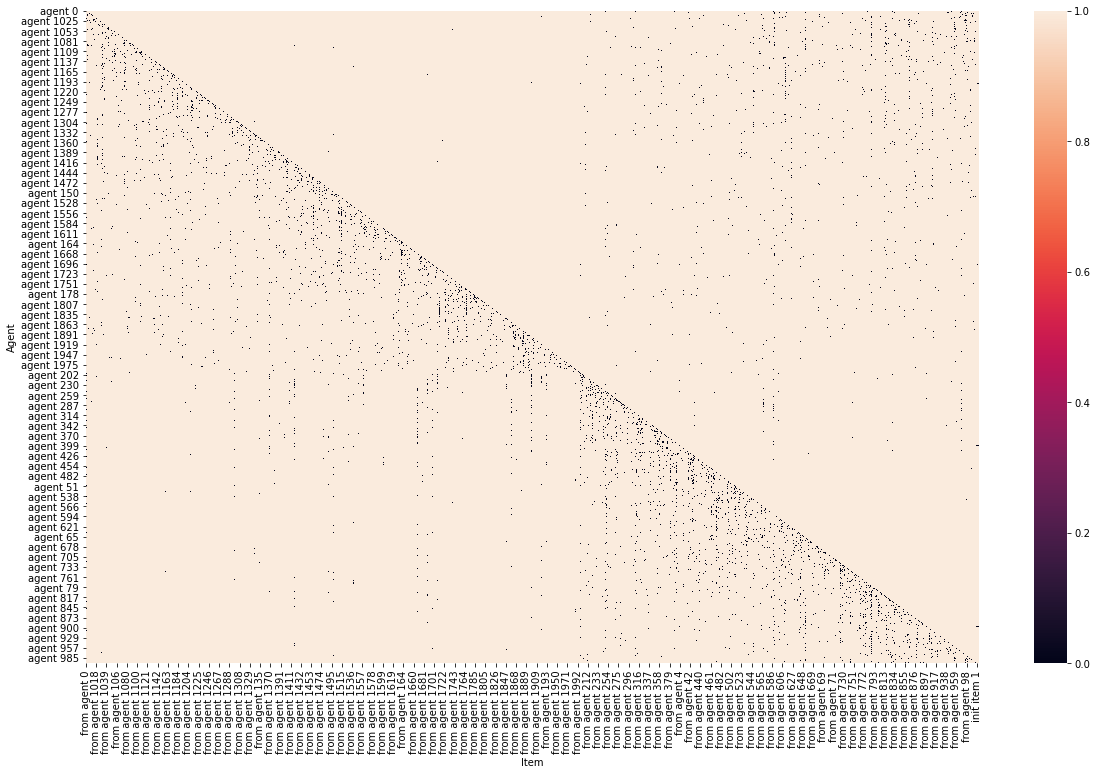

In [91]:
plt.figure(figsize=(20,12))
sns.heatmap(df_items.isna())

In [92]:
df_items.isna().sum().sort_values()

Item
from agent 788     1857
from agent 418     1867
from agent 1084    1877
from agent 654     1888
from agent 167     1893
                   ... 
from agent 1994    1999
from agent 1996    1999
from agent 1998    1999
from agent 1999    1999
from agent 1972    1999
Length: 2005, dtype: int64

In [93]:
df_items.isna().sum().iplot(kind = 'hist', bins = 100)

In [94]:
df_matrix_items = df_items.corr()

In [95]:
df_matrix_items

Item             from agent 0  from agent 1  from agent 10  from agent 100  \
Item                                                                         
from agent 0         1.000000      0.674200       0.333333             NaN   
from agent 1         0.674200      1.000000            NaN             NaN   
from agent 10        0.333333           NaN       1.000000             NaN   
from agent 100            NaN           NaN            NaN             1.0   
from agent 1000           NaN           NaN            NaN             NaN   
...                       ...           ...            ...             ...   
init item 0         -0.452267     -0.674200       0.232004             NaN   
init item 1          0.639602      1.000000            NaN             NaN   
init item 2         -0.452267     -0.674200       0.334719             NaN   
init item 3         -0.492366     -0.301511      -1.000000             NaN   
init item 4         -0.174078     -0.100000            NaN             NaN   

Item             from agent 1000  from agent 1001  from agent 1002  \
Item                                                                 
from agent 0                 NaN              NaN              NaN   
from agent 1                 NaN              NaN              NaN   
from agent 10                NaN              NaN              NaN   
from agent 100               NaN              NaN              NaN   
from agent 1000              1.0              NaN              NaN   
...                          ...              ...              ...   
init item 0                  NaN              NaN              NaN   
init item 1                  NaN              NaN              NaN   
init item 2                  NaN              NaN              NaN   
init item 3                  NaN              NaN              NaN   
init item 4                  NaN              NaN              NaN   

Item             from agent 1003  from agent 1004  from agent 1005  ...  \
Item                                                                ...   
from agent 0                 NaN              NaN              NaN  ...   
from agent 1                 NaN              NaN              NaN  ...   
from agent 10                NaN              NaN              NaN  ...   
from agent 100               NaN              NaN              NaN  ...   
from agent 1000              1.0              NaN              NaN  ...   
...                          ...              ...              ...  ...   
init item 0                  NaN              NaN              NaN  ...   
init item 1                  NaN              NaN              NaN  ...   
init item 2                  NaN              NaN              NaN  ...   
init item 3                  NaN              NaN              NaN  ...   
init item 4                  NaN              NaN              NaN  ...   

Item             from agent 995  from agent 996  from agent 997  \
Item                                                              
from agent 0                NaN             NaN             NaN   
from agent 1                NaN             NaN             NaN   
from agent 10               NaN             NaN             NaN   
from agent 100              NaN             NaN             NaN   
from agent 1000             NaN             NaN             NaN   
...                         ...             ...             ...   
init item 0                 NaN             NaN             NaN   
init item 1                 NaN             NaN             NaN   
init item 2                 NaN             NaN             NaN   
init item 3                 NaN             NaN             NaN   
init item 4                 NaN             NaN             NaN   

Item             from agent 998  from agent 999  init item 0  init item 1  \
Item                                                                        
from agent 0                NaN             NaN    -0.452267     0.63960

In [96]:
df_matrix_items.to_csv('df_matrix_items',sep=',')

<AxesSubplot:xlabel='Item', ylabel='Item'>

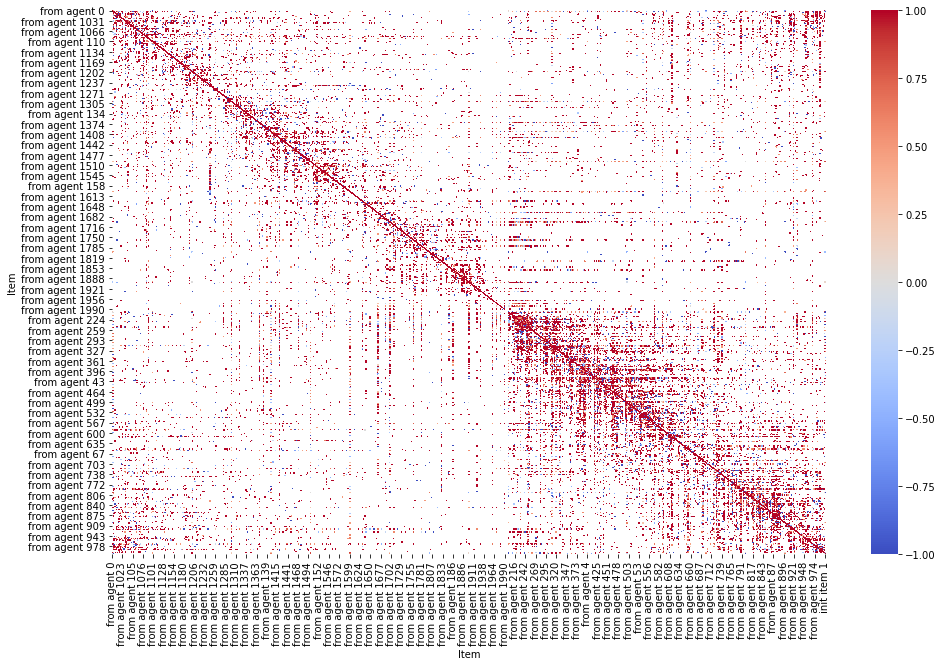

In [97]:
plt.figure(figsize=(16,10))
sns.heatmap(df_matrix_items,cmap='coolwarm')

In [98]:
df_agents = df_items.T

In [99]:
df_agents

Agent            agent 0  agent 1  agent 10  agent 100  agent 1000  \
Item                                                                 
from agent 0         1.0      1.0       0.0        NaN         NaN   
from agent 1         NaN      1.0       0.0        NaN         NaN   
from agent 10        NaN      NaN       1.0        NaN         NaN   
from agent 100       NaN      NaN       NaN        1.0         NaN   
from agent 1000      NaN      NaN       NaN        NaN         1.0   
...                  ...      ...       ...        ...         ...   
init item 0          0.0      0.0       1.0        NaN         NaN   
init item 1          1.0      1.0       0.0        NaN         NaN   
init item 2          0.0      0.0       1.0        NaN         NaN   
init item 3          0.0      0.0       0.0        NaN         NaN   
init item 4          0.0      0.0       0.0        NaN         NaN   

Agent            agent 1001  agent 1002  agent 1003  agent 1004  agent 1005  \
Item                                                                          
from agent 0            NaN         NaN         NaN         NaN         NaN   
from agent 1            NaN         NaN         NaN         NaN         NaN   
from agent 10           NaN         NaN         NaN         NaN         NaN   
from agent 100          NaN         NaN         NaN         NaN         NaN   
from agent 1000         NaN         NaN         1.0         NaN         NaN   
...                     ...         ...         ...         ...         ...   
init item 0             NaN         NaN         NaN         NaN         NaN   
init item 1             NaN         NaN         NaN         NaN         NaN   
init item 2             NaN         NaN         NaN         NaN         NaN   
init item 3             NaN         NaN         NaN         NaN         NaN   
init item 4             NaN         NaN         NaN         NaN         NaN   

Agent            ...  agent 990  agent 991  agent 992  agent 993  agent 994  \
Item             ...                                                          
from agent 0     ...        NaN        NaN        NaN        NaN        NaN   
from agent 1     ...        NaN        NaN        NaN        NaN        NaN   
from agent 10    ...        NaN        NaN        NaN        NaN        NaN   
from agent 100   ...        NaN        NaN        NaN        NaN        NaN   
from agent 1000  ...        NaN        NaN        NaN        NaN        NaN   
...              ...        ...        ...        ...        ...        ...   
init item 0      ...        NaN        NaN        NaN        NaN        NaN   
init item 1      ...        NaN        NaN        NaN        NaN        NaN   
init item 2      ...        NaN        NaN        NaN        NaN        NaN   
init item 3      ...        NaN        NaN        NaN        NaN        NaN   
init item 4      ...        NaN        NaN        NaN        NaN        NaN   

Agent            agent 995  agent 996  agent 997  agent 998  agent 999  
Item                                                                    
from agent 0           NaN        NaN        NaN        NaN        NaN  
from agent 1           NaN        NaN        NaN        NaN        NaN  
from agent 10          NaN        NaN        NaN        NaN        NaN  
from agent 100         NaN        NaN        NaN        NaN        NaN  
from agent 1000        NaN        NaN        NaN        NaN        NaN  
...                    ...        ...        ...        ...        ...  
init item 0            NaN        NaN        NaN        NaN        NaN  
init item 1            NaN        NaN        NaN        NaN        NaN  
init item 2            NaN        NaN        NaN        NaN        NaN  
init item 3            NaN        NaN        NaN        NaN        NaN  
init item 4            NaN        NaN        NaN        NaN        NaN  

[2005 rows x 2000 columns]

<AxesSubplot:xlabel='Agent', ylabel='Item'>

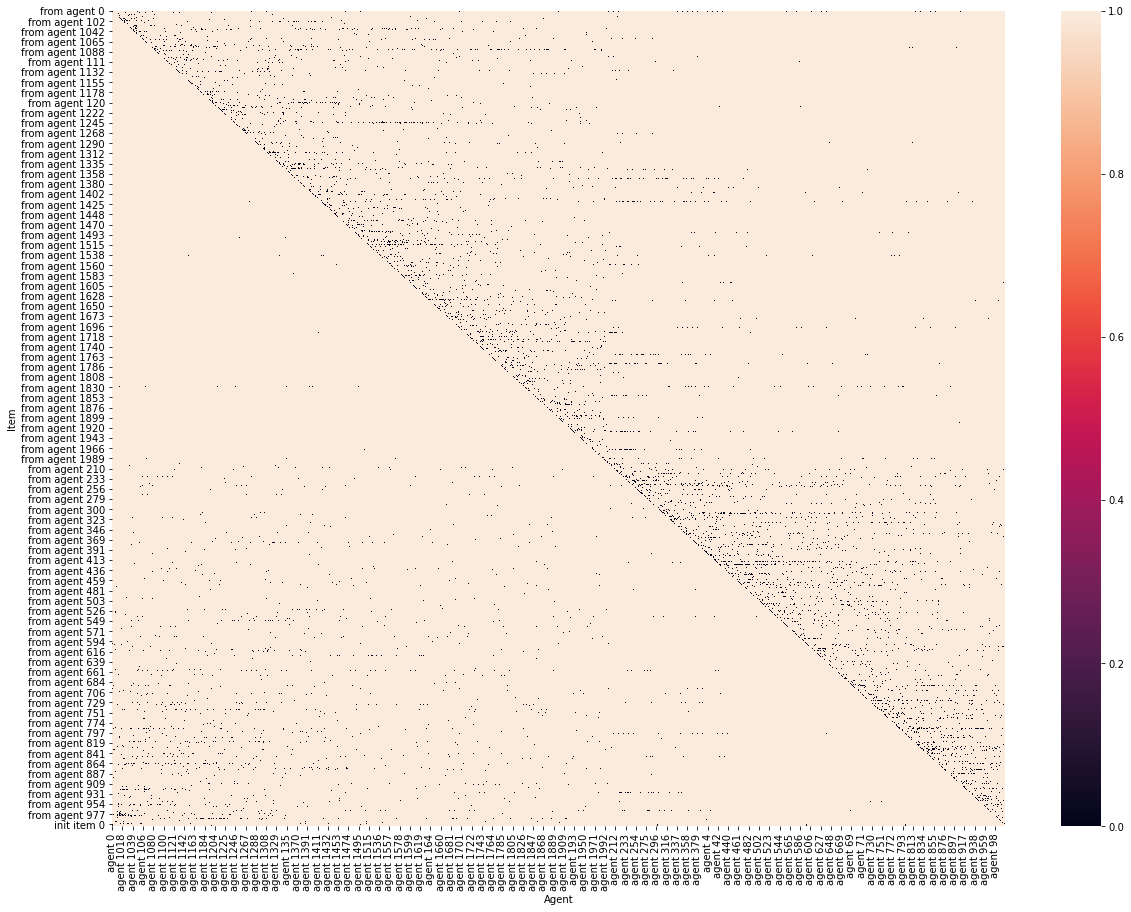

In [100]:
plt.figure(figsize=(20,15))
sns.heatmap(df_agents.isna())

In [101]:
df_agents.isna().sum().sort_values()

Agent
agent 1898    1989
agent 402     1989
agent 401     1989
agent 400     1989
agent 40      1989
              ... 
agent 4       1995
agent 3       1996
agent 2       1997
agent 1       1998
agent 0       1999
Length: 2000, dtype: int64

In [102]:
df_agents.isna().sum().iplot(kind = 'hist', bins = 100)
#there are 1995 agents who have not answered 1994 questions

In [103]:
df_matrix_agents = df_agents.corr()

In [104]:
df_matrix_agents

Agent       agent 0   agent 1  agent 10  agent 100  agent 1000  agent 1001  \
Agent                                                                        
agent 0         1.0  1.000000 -0.500000        NaN         NaN         NaN   
agent 1         1.0  1.000000 -0.547723        NaN         NaN         NaN   
agent 10       -0.5 -0.547723  1.000000        NaN         NaN         NaN   
agent 100       NaN       NaN       NaN        1.0         NaN         NaN   
agent 1000      NaN       NaN       NaN        NaN         1.0         NaN   
...             ...       ...       ...        ...         ...         ...   
agent 995       NaN       NaN       NaN        NaN         NaN         NaN   
agent 996       NaN       NaN       NaN        NaN         NaN         NaN   
agent 997       NaN       NaN       NaN        NaN         NaN         NaN   
agent 998       NaN       NaN       NaN        NaN        -1.0         NaN   
agent 999       NaN       NaN       NaN        NaN         NaN         NaN   

Agent       agent 1002  agent 1003  agent 1004  agent 1005  ...  agent 990  \
Agent                                                       ...              
agent 0            NaN         NaN         NaN         NaN  ...        NaN   
agent 1            NaN         NaN         NaN         NaN  ...        NaN   
agent 10           NaN         NaN         NaN         NaN  ...        NaN   
agent 100          NaN         NaN         NaN         NaN  ...        NaN   
agent 1000         NaN         NaN         NaN         NaN  ...        NaN   
...                ...         ...         ...         ...  ...        ...   
agent 995          0.5         NaN         NaN         NaN  ...        NaN   
agent 996          NaN         NaN         NaN         NaN  ...        NaN   
agent 997          NaN         NaN         NaN         NaN  ...        NaN   
agent 998          NaN         NaN         NaN         NaN  ...        NaN   
agent 999          NaN         NaN   -0.333333         NaN  ...        NaN   

Agent       agent 991  agent 992  agent 993  agent 994  agent 995  agent 996  \
Agent                                                                          
agent 0           NaN        NaN        NaN        NaN        NaN        NaN   
agent 1           NaN        NaN        NaN        NaN        NaN        NaN   
agent 10          NaN        NaN        NaN        NaN        NaN        NaN   
agent 100         NaN        NaN        NaN        NaN        NaN        NaN   
agent 1000        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
agent 995         NaN        NaN        NaN        NaN        1.0        NaN   
agent 996         NaN        NaN        NaN        NaN        NaN        1.0   
agent 997         NaN        NaN        NaN        NaN        NaN       -1.0   
agent 998         NaN        NaN        NaN        NaN        NaN        NaN   
agent 999         NaN        NaN        NaN        NaN        NaN        NaN   

Agent       agent 997  agent 998  agent 999  
Agent                                        
agent 0           NaN        NaN        NaN  
agent 1           NaN        NaN        NaN  
agent 10          NaN        NaN        NaN  
agent 100         NaN        NaN        NaN  
agent 1000        NaN       -1.0        NaN  
...               ...        ...        ...  
agent 995         NaN        NaN        NaN  
agent 996        -1.0        NaN        NaN  
agent 997         1.0        NaN        NaN  
agent 998         NaN        1.0        NaN  
agent 999         NaN        NaN        1.0  

[2000 rows x 2000 columns]

In [105]:
df_matrix_agents.to_csv('df_matrix_agents',sep=',')

<AxesSubplot:xlabel='Agent', ylabel='Agent'>

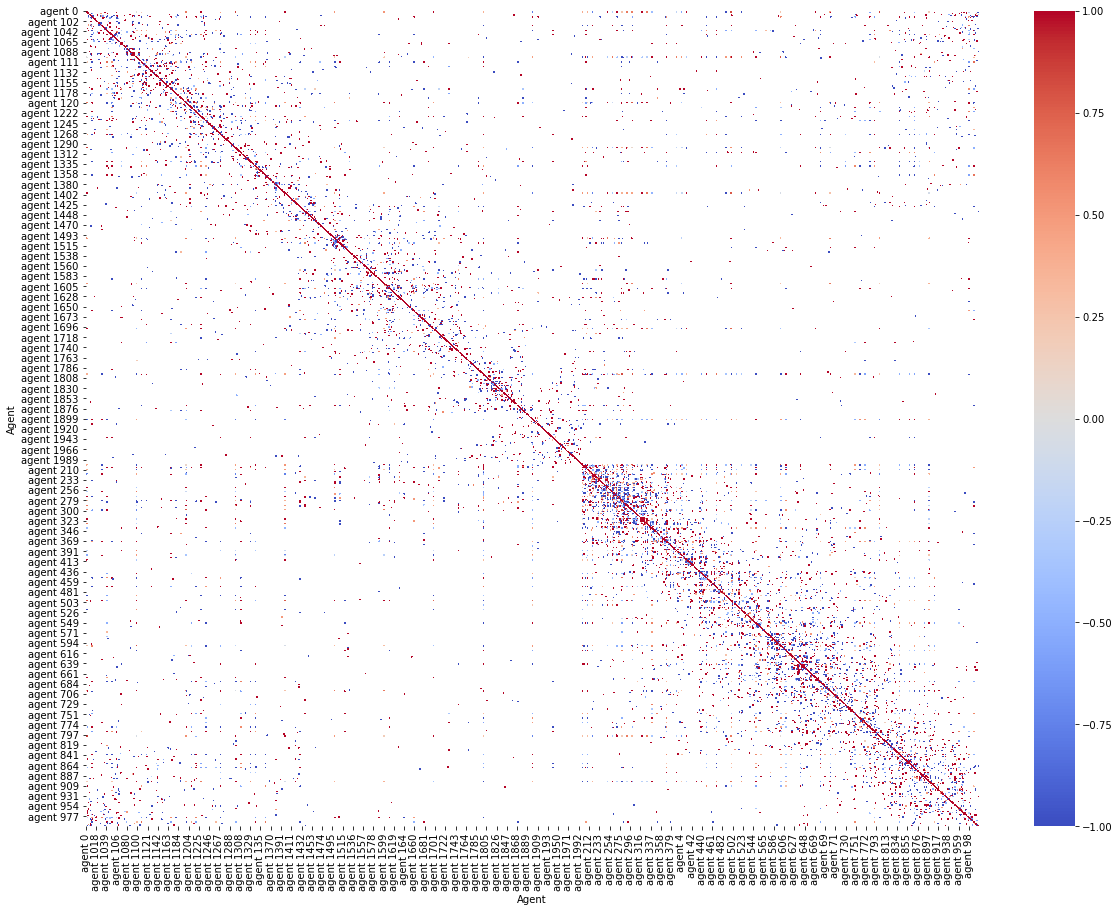

In [106]:
plt.figure(figsize=(20,15))
sns.heatmap(df_matrix_agents,cmap='coolwarm')

# Machine Learning Using Logistic Regression

###### Convert Agent and Items into dummy value

In [55]:
df_tidy

Agent             Item  Answer
0         agent 0      init item 1       1
1         agent 0     from agent 0       1
2         agent 0      init item 0       0
3         agent 0      init item 2       0
4         agent 0      init item 3       0
...           ...              ...     ...
31940  agent 1999  from agent 1347       1
31941  agent 1999  from agent 1999       1
31942  agent 1999  from agent 1984       0
31943  agent 1999  from agent 1987       0
31944  agent 1999  from agent 1946       0

[31945 rows x 3 columns]

In [56]:
df_agent_dummy = pd.get_dummies(df_tidy['Agent'],drop_first=True)

In [57]:
df_agent_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31945 entries, 0 to 31944
Columns: 1999 entries, agent 1 to agent 999
dtypes: uint8(1999)
memory usage: 60.9 MB


In [58]:
df_item_dummy = pd.get_dummies(df_tidy['Item'],drop_first=True)

In [59]:
df_item_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31945 entries, 0 to 31944
Columns: 2004 entries, from agent 1 to init item 4
dtypes: uint8(2004)
memory usage: 61.1 MB


In [60]:
df_answer = df_tidy.drop(['Agent','Item'],axis=1)

In [61]:
df_dummy = pd.concat([df_agent_dummy,df_item_dummy,df_answer],axis=1)

In [62]:
df_dummy.head()

agent 1  agent 10  agent 100  agent 1000  agent 1001  agent 1002  \
0        0         0          0           0           0           0   
1        0         0          0           0           0           0   
2        0         0          0           0           0           0   
3        0         0          0           0           0           0   
4        0         0          0           0           0           0   

   agent 1003  agent 1004  agent 1005  agent 1006  ...  from agent 996  \
0           0           0           0           0  ...               0   
1           0           0           0           0  ...               0   
2           0           0           0           0  ...               0   
3           0           0           0           0  ...               0   
4           0           0           0           0  ...               0   

   from agent 997  from agent 998  from agent 999  init item 0  init item 1  \
0               0               0               0            0            1   
1               0               0               0            0            0   
2               0               0               0            1            0   
3               0               0               0            0            0   
4               0               0               0            0            0   

   init item 2  init item 3  init item 4  Answer  
0            0            0            0       1  
1            0            0            0       1  
2            0            0            0       0  
3            1            0            0       0  
4            0            1            0       0  

[5 rows x 4004 columns]

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df_dummy.drop('Answer',axis=1), df_dummy['Answer'], test_size=0.33, random_state=42)

In [65]:
from sklearn.linear_model import LogisticRegression

In [66]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [67]:
predictions = logmodel.predict(X_test)

In [68]:
from sklearn.metrics import classification_report, confusion_matrix

In [69]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.67      0.38      0.49      2948
           1       0.79      0.93      0.86      7594

    accuracy                           0.77     10542
   macro avg       0.73      0.65      0.67     10542
weighted avg       0.76      0.77      0.75     10542



In [70]:
print(max_turn)
print(confusion_matrix(y_test,predictions)) 

15
[[1127 1821]
 [ 559 7035]]


# Machine Learning Using KNN

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [72]:
knn = KNeighborsClassifier(n_neighbors = 1)

In [73]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [74]:
pred_knn = knn.predict(X_test)

In [75]:
print(confusion_matrix(y_test, pred_knn))
print(classification_report(y_test, pred_knn))

[[1148 1800]
 [1741 5853]]
              precision    recall  f1-score   support

           0       0.40      0.39      0.39      2948
           1       0.76      0.77      0.77      7594

    accuracy                           0.66     10542
   macro avg       0.58      0.58      0.58     10542
weighted avg       0.66      0.66      0.66     10542



In [76]:
error_rate = []
for i in range(1,50):
    knn_best = KNeighborsClassifier(n_neighbors = i)
    knn_best.fit(X_train, y_train)
    pred_knn_best = knn_best.predict(X_test)
    error_rate.append(np.mean(pred_knn_best != y_test))

Text(0, 0.5, 'Error Rate')

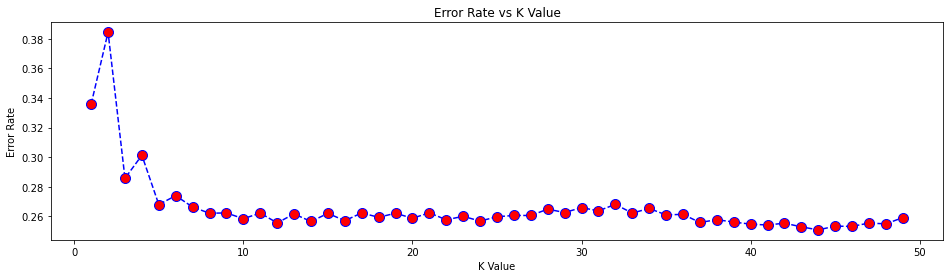

In [77]:
plt.figure(figsize = (16,4))
plt.plot(range(1,50),error_rate,
        color = 'blue', linestyle = '--', 
        marker = 'o', markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate vs K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')

In [78]:
knn44 = KNeighborsClassifier(n_neighbors=44)

In [79]:
knn44.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=44)

In [80]:
pred_knn44 = knn44.predict(X_test)

In [81]:
print(confusion_matrix(y_test, pred_knn44))
print(classification_report(y_test, pred_knn44))

[[ 889 2059]
 [ 585 7009]]
              precision    recall  f1-score   support

           0       0.60      0.30      0.40      2948
           1       0.77      0.92      0.84      7594

    accuracy                           0.75     10542
   macro avg       0.69      0.61      0.62     10542
weighted avg       0.73      0.75      0.72     10542



# Random Forest Model

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
rfc = RandomForestClassifier(n_estimators=200)

In [85]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [86]:
pred_rfc = rfc.predict(X_test)

In [88]:
print(confusion_matrix(y_test, pred_rfc))
print('\n')
print(classification_report(y_test, pred_rfc))

[[1640 1308]
 [ 882 6712]]


              precision    recall  f1-score   support

           0       0.65      0.56      0.60      2948
           1       0.84      0.88      0.86      7594

    accuracy                           0.79     10542
   macro avg       0.74      0.72      0.73     10542
weighted avg       0.78      0.79      0.79     10542



# Agent added Item Table 

In [1112]:
fave_list = []
for i in agent_list:
    fave_list.append(i.like[-1].name)

In [1113]:
agent_name = []
for i in agent_list:
    agent_name.append(i.name)

In [1114]:
df_ai = pd.DataFrame({'Agents':agent_name, 'Items':fave_list})

In [1115]:
df_ai

Agents            Items
0        agent 0     from agent 0
1        agent 1     from agent 1
2        agent 2     from agent 2
3        agent 3     from agent 3
4        agent 4     from agent 4
...          ...              ...
1995  agent 1995  from agent 1995
1996  agent 1996  from agent 1996
1997  agent 1997  from agent 1997
1998  agent 1998  from agent 1998
1999  agent 1999  from agent 1999

[2000 rows x 2 columns]

# Conclusion

When tolerance is 10%, q_per_tradeoff = 8, we get 11.5 confirmed answers for each 10 questions asked.
It makes more sense to use tradeoff+binary if we know the tolerance is 10% or less

# Ignore anything below this cell

In [ ]:
# ========storing a,b in two np array is impossible to work with when tracking the index of each item=============

number_of_likes = np.zeros(initial_no_of_items)  # record how many times each item was checked
number_of_dislikes = np.zeros(initial_no_of_items) # record how many times each item was ignored
item_list = [] #list that holds ALL possible items, the whole database
item_list_temp = [] # list that holds items that are eligible to be pushed to the current agent.
diff_list = []
agent_list = []
beta_list = []
max_beta_index = []
item_dict = {}

#prep the initial questionaire
for i in range(initial_no_of_items):
    init_item = Item()
    item_list.append(init_item)


#prep the initial questionaire
for i in range(initial_no_of_items):
    init_item = Item()
    item_list.append(init_item)

for each_agent in range(number_of_agents):
    agent = Agent()
    turn = 1
    
    # Because we only ask 5 rounds, and 2 questions per round, and we have 5 initial questions, 
    # and each agent add one item to the list, by the time the sixth agent enter the survey, 
    # there are 10 questions in the item_list. That's how the "<=max_round*2-initial_no_of_items" is chosen.
    if each_agent <= max_round*2-initial_no_of_items: 
        for count,i in enumerate(item_list):
            if abs(agent.attr - i.attr) <= tolerance:
                agent.choose(i) # choose method appends this item to its like list for this agent
                number_of_likes[count] += 1
            else:
                agent.not_choose(i) # appends this item to its dislike list for this agent
                number_of_dislikes[count] += 1

        
    # from the seventh agent up, we start to ask trade-off and binary alternatively because the number of questions
    # is greater than the number of questions we are allowed to ask each agent
    else:

        # get all beta value for each item
        for count, i in enumerate(item_list):
            a = number_of_likes[count] + 1
            b = number_of_dislikes[count] + 1
            beta_list.append(np.random.beta(a,b))
        for i in range(len(item_list)):
            max_beta_index.append = np.argmax(beta_list) # max_beta_index contains the index of items of largest 5 beta value in the item_list
            beta_list[max_beta_index[-1]] -= 1 #make the largest smallest to expose the next largest number
        while turn <= max_turn:
            for i in max_beta_index[(turn-1)*q_per_tradeoff:min(turn*q_per_tradeoff,len(max_beta_index))]: # interval of 5. if less than 5 remaining, use the length of the list
                diff_list.append(agent.attr - item_list[i].attr)    
            idx_min = max_beta_index[np.argmin(diff_list)+(turn-1)*q_per_tradeoff] # I need idx_min so that I can find the item and a+=1 to it.
            if agent.attr - item_list[idx_min].attr > tolerance:
                for i in max_beta_index[(turn-1)*q_per_tradeoff:min(turn*q_per_tradeoff,len(max_beta_index))]:
                    number_of_dislikes[i] += 1
                turn += 1
            else:
                

    
    
    # add an item to item_list based on agent attr.
    new_item = Item()
    new_item.attr = agent.attr
    item_list.append(new_item)
    agent.choose(new_item)



In [178]:
Item

__main__.Item

In [181]:
Item()

### Thompson Sampling 

In [6]:
number_of_agents = 100
max_items_per_questionaire = 30
initial_no_of_items = 5

In [ ]:
number_of_checks = np.zeros(initial_no_of_items)  # record how many times each item was checked
number_of_ignores = np.zeros(initial_no_of_items) # record how many times each item was ignored
item_list = [] #list that holds ALL possible items, the whole database
diff_list = []
agent_list = []
beta_list = []
max_beta_index = []
chosen_attr_list = []
agent_attr_list = []

#prep the initial questionaire
for i in range(initial_no_of_items):
    init_item = Item()
    item_list.append(init_item)

for each_agent in range(number_of_agents):
    agent = Agent() # give a random attr in the __init__ method
    if len(item_list) <= max_items_per_questionaire: # if the items in the questionaire are less than 30, ask all items:
        for item in item_list:#item_list is a list of items
            diff_list.append(abs(agent.attr - item.attr)) # add threshold for multiple choice in the future
        idx_min = np.argmin(diff_list)
        
        number_of_checks[idx_min] += 1
        for rest in range(len(item_list)): # b += 1 for those ignored items
            if rest != idx_min:
                number_of_ignores += 1        
        
        
    else:
        for count,item in enumerate(item_list): #get beta value for each item in current round
            a = number_of_checks[count]+1
            b = number_of_ignores[count]+1
            item_beta = np.random.beta(a,b) #thompson sampling
            beta_list.append(item_beta) # beta_list consists of beta value for each item in current round
        for i in range(max_items_per_questionaire):#get the largest 30 beta index
            max_beta_index.append(np.argmax(beta_list)) # max_beta_index contains the index of items of largest 30 beta value
            beta_list[max_beta_index[-1]] = -1 #make the largest smallest to expose the next largest number
        for i in max_beta_index:
            diff_list.append(abs(agent.attr - item_list[i].attr))
        idx_min = max_beta_index[np.argmin(diff_list)] # np.argmin(diff_list) is just the index in the max_beta_index
                                                  # the value of max_beta_index returns the index of item whose attr is closest

        number_of_checks[idx_min] += 1
        for rest in max_beta_index: # b += 1 for those ignored items
            if rest != idx_min:
                number_of_ignores += 1

    chosen_attr_list.append(item_list[idx_min].attr)
    agent_attr_list.append(agent.attr)
    
    #register agenct choice       
    agent.choose(item_list[idx_min])
    #add agent to agent list
    agent_list.append(agent)       
            

    #agent add new item     
    new_item = Item()
    new_item.attr = agent.attr
    item_list.append(new_item)     
    number_of_checks = np.append(number_of_checks,0) 
    number_of_ignores = np.append(number_of_ignores,0)
    diff_list = []
    max_beta_index = []
    beta_list = []
   

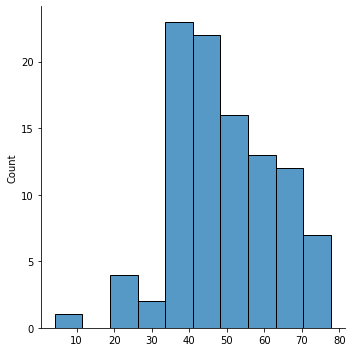

In [8]:
# attributes of chosen items
sns.displot(chosen_attr_list)

In [ ]:
generate_beta_value_for_items()

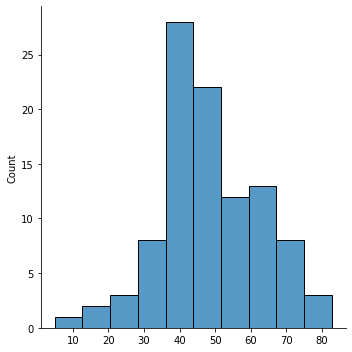

In [9]:
# attributes of agents
sns.displot(agent_attr_list)

In [10]:
fig = px.scatter(
    x=agent_attr_list, y=chosen_attr_list, opacity=0.65,
    trendline='ols', trendline_color_override='darkblue'
)
fig.show()

### random sample 

In [11]:
item_list = [] #list that holds ALL possible items, the whole database
diff_list = []
agent_list = []
chosen_attr_list = []
agent_attr_list = []

#prep the initial questionaire
for i in range(initial_no_of_items):
    init_item = Item()
    item_list.append(init_item)

for each_agent in range(number_of_agents):
    agent = Agent() # give a random attr in the __init__ method
    if len(item_list) <= max_items_per_questionaire: # if the items in the questionaire are less than 30, ask all items:
        for item in item_list:#item_list is a list of items
            diff_list.append(abs(agent.attr - item.attr))
        idx_min = np.argmin(diff_list)
    else:
        random.shuffle(item_list)
        for i in range(max_items_per_questionaire):
            diff_list.append(abs(agent.attr - item_list[i].attr))
        idx_min = np.argmin(diff_list)


    chosen_attr_list.append(item_list[idx_min].attr)
    agent_attr_list.append(agent.attr)
    
    #register agenct choice       
    agent.choose(item_list[idx_min])
    #add agent to agent list
    agent_list.append(agent)       
            

    #agent add new item     
    new_item = Item()
    new_item.attr = agent.attr
    item_list.append(new_item)     
    diff_list = []                

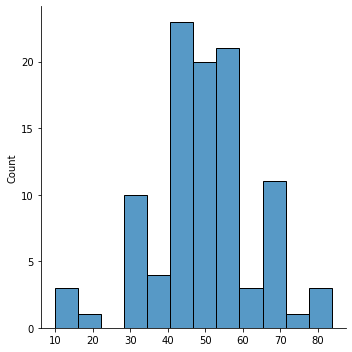

In [12]:
# attributes of chosen items
sns.displot(chosen_attr_list )

In [182]:
lst1

[1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [183]:
def myfun(l):
    l[0]=999
    return l

In [184]:
l = myfun(lst1)

In [185]:
l

[999, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [186]:
lst1

[999, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [187]:
a=5

In [188]:
def myfun1(x):
    x +=1
    return x

In [189]:
xx = myfun1(a)

In [190]:
xx

6

In [191]:
a

5

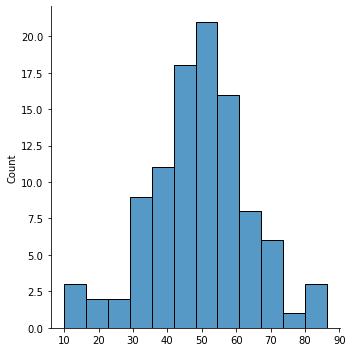

In [13]:
# attributes of agents
sns.displot(agent_attr_list)

In [14]:
fig = px.scatter(
    x=agent_attr_list, y=chosen_attr_list, opacity=0.65,
    trendline='ols', trendline_color_override='darkblue'
)
fig.show()

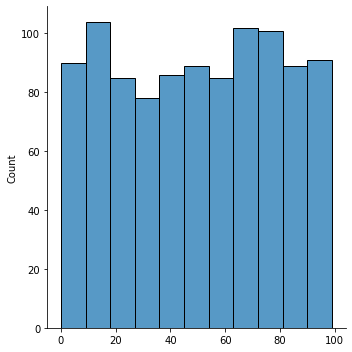

In [17]:
lst = []
for i in range(1000):
    lst.append(np.random.randint(100))
sns.displot(lst)